# Predicting Flight Delays <Title here>

Team 07 Authors: Charles Carlson, Justin Wong, Max Hoff, Mohamed Sondo, Shehzad Shahbuddin
  
W261 Final Report

##### Code Functions

In [0]:
# import libraries
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from pyspark.sql.functions import year, month, hour, when, lit, to_date
from pyspark.sql.types import IntegerType

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
import seaborn as sns
import pandas as pd

# Set up credentials and set spark config for blob storage access
blob_container = "storage-container" # The name of your container created in https://portal.azure.com
storage_account = "w261storage" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261-section3-group2" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "saskey-g" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

sc = spark.sparkContext


def plot_corr_matrix(correlations,attr,fig_no, fig_title = 'Specific Attributes'):
    fig=plt.figure(fig_no, figsize=(18,18))
    ax=fig.add_subplot(111)
    ax.set_title(f"Correlation Matrix for {fig_title}")

    ax.set_yticklabels(attr)
    ax.set_xticklabels(attr, rotation=45)
    ax.xaxis.tick_bottom()
    cax=ax.matshow(correlations,vmax=1,vmin=-1, cmap='seismic')
    fig.colorbar(cax)
    ax.yaxis.set_major_locator(MultipleLocator(1)) 
    ax.xaxis.set_major_locator(MultipleLocator(1))
    plt.show()

def corr_vis(df, features, meas='DEP_DEL15'):
    ## Create a blank dataframe that calculates all the correlations to DEP_DEL15
    vis = pd.DataFrame()
    vis['feature'] = features
    vis['spearman'] = df[meas].values
#     vis['spearman'] = [df[f].corr(df[meas], 'spearman') for f in features]
    #[print(str(features[f]) + ": " + str(spr['spearman'][f])) for f in range(len(features))]
    
    vis = vis.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=vis, y='feature', x='spearman', orient='h')
    
    ## Chart design
    ax.set(xlabel='correlation')
    ax.set(title='Correlation of all features to {meas}'.format(meas=meas)) 
    return vis


feature_columns =['NET_FLOW_2h',
                 'NET_FLOW_3h',
                 'NET_FLOW_4h',
                 'NET_FLOW_5h',
                 'NET_FLOW_SQUARED',
                 'NET_FLOW_SQUARED_1h',
                 'NET_FLOW_SQUARED_2h',
                 'NET_FLOW_SQUARED_3h',
                 'NET_FLOW_SQUARED_4h',
                 'NET_FLOW_SQUARED_5h',
                 'PAGERANK_SCORE',
                 'ALREADY_DELAYED',
                 'dest_pred_dry_bulb',
                 'dest_pred_sum_precipitation_bulb',
                 'dest_pred_humidity',
                 'dest_pred_pressure',
                 'dest_pred_visibility',
                 'dest_pred_wet_bulb_temp',
                 'dest_pred_wind_direction',
                 'dest_pred_wind_gust',
                 'dest_pred_wind_speed',
                 'dest_pred_dew',
                 'origin_pred_dry_bulb',
                 'origin_pred_sum_precipitation_bulb',
                 'origin_pred_humidity',
                 'origin_pred_pressure',
                 'origin_pred_visibility',
                 'origin_pred_wet_bulb_temp',
                 'origin_pred_wind_direction',
                 'origin_pred_wind_gust',
                 'origin_pred_wind_speed',
                 'origin_pred_dew']

master_df = spark.read.parquet(f"{blob_url}/master.v4")
master_df = master_df.withColumn("ALREADY_DELAYED", master_df["ALREADY_DELAYED"].cast(IntegerType())).na.fill(value = -1)
master_df.printSchema()

/databricks/python/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
 warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
root
-- _utc_dept_ts: timestamp (nullable = true)
-- _utc_dept_minus2_ts: timestamp (nullable = true)
-- _utc_dept_actual_ts: timestamp (nullable = true)
-- _utc_arr_ts: timestamp (nullable = true)
-- _utc_arr_actual_ts: timestamp (nullable = true)
-- _dep_time_str: string (nullable = true)
-- _local_dept_ts: timestamp (nullable = true)
-- _local_dept_minus2_ts: timestamp (nullable = true)
-- _local_dept_actual_ts: timestamp (nullable = true)
-- _local_at_src_airport_arr_ts: timestamp (nullable = true)
-- _local_at_src_airport_arr_actual_ts: timestamp (nullable = true)
-- QUARTER: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- FL_DATE: string (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- OP_CARRIER_FL_NUM: integer (nullable = true)
-- ORIGIN_AIRPORT_ID: integer (nullable = true)
-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_CITY_NAME: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- ORIGIN_STATE_FIPS: integer (nullable = true)
-- ORIGIN_STATE_NM: string (nullable = true)
-- ORIGIN_WAC: integer (nullable = true)
-- DEST_AIRPORT_ID: integer (nullable = true)
-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
-- DEST_CITY_MARKET_ID: integer (nullable = true)
-- DEST: string (nullable = true)
-- DEST_CITY_NAME: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEST_STATE_FIPS: integer (nullable = true)
-- DEST_STATE_NM: string (nullable = true)
-- DEST_WAC: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DEP_TIME: integer (nullable = true)
-- DEP_DELAY: double (nullable = false)
-- DEP_DELAY_NEW: double (nullable = false)
-- DEP_DEL15: double (nullable = false)
-- DEP_DELAY_GROUP: integer (nullable = true)
-- DEP_TIME_BLK: string (nullable = true)
-- TAXI_OUT: double (nullable = false)
-- WHEELS_OFF: integer (nullable = true)
-- WHEELS_ON: integer (nullable = true)
-- TAXI_IN: double (nullable = false)
-- CRS_ARR_TIME: integer (nullable = true)
-- ARR_TIME: integer (nullable = true)
-- ARR_DELAY: double (nullable = false)
-- ARR_DELAY_NEW: double (nullable = false)
-- ARR_DEL15: double (nullable = false)
-- ARR_DELAY_GROUP: integer (nullable = true)
-- ARR_TIME_BLK: string (nullable = true)
-- CANCELLED: double (nullable = false)
-- CANCELLATION_CODE: string (nullable = true)
-- DIVERTED: double (nullable = false)
-- CRS_ELAPSED_TIME: double (nullable = false)
-- ACTUAL_ELAPSED_TIME: double (nullable = false)
-- AIR_TIME: double (nullable = false)
-- FLIGHTS: double (nullable = false)
-- DISTANCE: double (nullable = false)
-- DISTANCE_GROUP: integer (nullable = true)
-- CARRIER_DELAY: double (nullable = false)
-- WEATHER_DELAY: double (nullable = false)
-- NAS_DELAY: double (nullable = false)
-- SECURITY_DELAY: double (nullable = false)
-- LATE_AIRCRAFT_DELAY: double (nullable = false)
-- FIRST_DEP_TIME: integer (nullable = true)
-- TOTAL_ADD_GTIME: double (nullable = false)
-- LONGEST_ADD_GTIME: double (nullable = false)
-- origin_airport_iata: string (nullable = true)
-- origin_airport_tz: string (nullable = true)
-- origin_airport_type: string (nullable = true)
-- origin_airport_elevation: string (nullable = true)
-- origin_airport_iso_country: string (nullable = true)
-- origin_airport_iso_region: string (nullable = true)
-- origin_airport_ws_station_id: string (nullable = true)
-- dest_airport_iata: string (nullable = tr

# Abstract

In 2022 airline delays and cancellations have increased substantially. In the week leading up the 4th of July 2022, 21.8% of flights were delayed and 2.4% were cancelled. To help airlines better prepare for delays, we're building a model to predict flight delays greater than 15 minutes.

Previously, we joined airline and airport data from the US Department of Transportation and weather data from the National Oceanic and Atmospheric Administration to provide features and a response variable (`DEP_DELAY15`). We also performed EDA to get a better understanding of what features to engineer.

In this phase, we developed novel features and tightened up our modeling pipeline, implementing undersampling, Cross Validation, and Gridsearch. We created new features, such as airport congestion graph features, airport 'page-rank' scores, data on the aircraft gathered 2 hours prior to the departure, and predicted future weather.

By comparing models on weighted precision and weighted recall, our best model is a random forest classifier with a .760 weighted precision and .797 weighted recall on the 2021 evaluation dataset, training on 2015 - 2019.

# EDA and Feature Engineering

We designed several new features to capture more attributes about departure delays. These feature families can be grouped into:
* Graph based Features
  * Windowing features
  * PageRank
* Cascading Delay / Lagged Features
* Predicted Weather

## Graph based Features

In an attempt to represent the airports and flight data as a graph and capture airport congestion due to flight volume, we created three notable graph-based features using two different graph definitions.

### Space-Time Graph
Two primary features (`NET_FLOW` and `FLOW_RATIO`) were created by treating scheduled arriving and departing flights from each airport at every hour of the day. These features are ultimately the node weights of our graph.

To prevent possible data leakage of using flight information 2 hours before which would give up delays, the incoming and outgoing flights were counted purely using the scheduled timestamps in the flight dataset. Even if a flight was cancelled, it would still be counted toward going to its destination, as if the flight was never cancelled. 

#### Graph Definition
  For our graph definition, we create a space-time graph, accounting for airport location and time.

  Each node represents a unique airport and a flight timestamp truncated by its hour. For example, the timestamp `2020-03-21T01:55:00.000+0000` would be truncated to `2020-03-21T01:00:00.000+0000` so that inflow/outflow of each node are counted within the same hour.

  Edges represents the flights and time between nodes. Edges exist if there is an incoming flight at the same airport as a departing flight. The feature we built is based on the weight of such edge. The terms "incoming" is interchangeable with "arriving", while "outgoing" is interchangeable with "departing".

#### Developing `NET_FLOW` and `FLOW_RATIO` as the Edge Weights
  To make this feature effective, we simulated "traffic" by calculating the weights of nodes. The node weights are based on the inflow and out flow at each node.
  
  In graph terminology, the in-degree and out-degree determine the node weight. `NET_FLOW` is the in-degree minus out-degree, while `FLOW_RATIO` is the ratio between in-degree and out-degree.
  
  Hence, we create the following columns as our graph-based features by grouping each airport and truncated hour aggregating on counting the scheduled departure and arrival counts across the entire joined flight dataset, resulting in the following columns:
- `NET_FLOW`: the net difference of incoming and outgoing flights from the same airport within the same hour.
- `NET_FLOW_SQUARED`: very postive and very negative net flows should be treated the same. Intuitively, this means having a large number of incoming flights should have the same flight delay effect as having a large number of outgoing flights. To capture this, we decided to square `NET_FLOW`, so that the numbers are all positive.
- `FLOW_RATIO`: the ratio  of depatures / arriving flights. See the `Discussion of Key Findings` section for more details.

For more details on the implementation of this feature, see [this notebook](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/388464713030782/command/849916349902224).

#### Deriving More Columns

##### Windowed `NET_FLOW` and `FLOW_RATIO`
  As we experimented with this feature, we found it was very effective and became one of the more important features for a Random Forest. In addition to capturing the immediate `NET_FLOW` and `FLOW_RATIO` within the same hour at a given airport, we wanted to capture the `NET_FLOW` and `FLOW_RATIO` in different time windows before flight times. As a result, we created the following columns to capture the "traffic" in the past X hours of a flight:
  - `FLOW_RATIO_1h`: cumulative `FLOW_RATIO` in the past 2 hours before a flight.
  - `FLOW_RATIO_2h`: cumulative `FLOW_RATIO` in the past 3 hours before a flight.
  - `FLOW_RATIO_3h`: cumulative `FLOW_RATIO` in the past 4 hours before a flight.
  - `FLOW_RATIO_4h`: cumulative `FLOW_RATIO` in the past 5 hours before a flight.
  - `FLOW_RATIO_5h`: cumulative `FLOW_RATIO` in the past 6 hours before a flight.

##### Squared `NET_FLOW`
  We also wanted the magnitude of `NET_FLOW` to be important because in an airport, having many *arriving* flights would have the same effect on airway traffic as having many *departing* flights. The magnitude of net flow dictates how much traffic an airport would have because there would only be limited space for takeoffs and landing. Further, to exagerate a worsening effect on very positive or very negative `NET_FLOW`, we created a `NET_FLOW_SQUARED` column by simply squaring `NET_FLOW`.

In [0]:
graph_flow_df = spark.read.parquet((f"{blob_url}/graph_net_flow.v10"))
print(f"There are {graph_flow_df.count()} rows")

There are 6752851 rows

#### EDA of Net Flow, Squared Net Flow, and Flow Ratio

##### Analyzing Net Flow and Squared Net Flow
  Using SFO as an example airport, a bigger window results in the cumulative net flow being closer to zero because there is more time for incoming and outgoing flights to balance each other out. However, the more granular we get, the more traffic we see, especially in during peak hours.
  
  Naturally if the magnitude of `NET_FLOW` is high, `NET_FLOW_SQUARED`is also high because they are directly related simply by squaring net_flow.

In [0]:
display(graph_flow_df[graph_flow_df['AIRPORT']=='SFO'].orderBy('_utc_ts_trunc', 'AIRPORT'))

_utc_ts_trunc _utc_ts_minus1_trunc _utc_ts_minus2_trunc _utc_ts_minus3_trunc _utc_ts_minus4_trunc _utc_ts_minus5_trunc AIRPORT AIRPORT_ID ARRIVAL_COUNT ARRIVAL_COUNT_1h ARRIVAL_COUNT_2h ARRIVAL_COUNT_3h ARRIVAL_COUNT_4h ARRIVAL_COUNT_5h ARRIVAL_COUNT_M1 ARRIVAL_COUNT_M2 ARRIVAL_COUNT_M3 ARRIVAL_COUNT_M4 ARRIVAL_COUNT_M5 DEPARTURE_COUNT DEPARTURE_COUNT_1h DEPARTURE_COUNT_2h DEPARTURE_COUNT_3h DEPARTURE_COUNT_4h DEPARTURE_COUNT_5h DEPARTURE_COUNT_M1 DEPARTURE_COUNT_M2 DEPARTURE_COUNT_M3 DEPARTURE_COUNT_M4 DEPARTURE_COUNT_M5 FLOW_RATIO FLOW_RATIO_1h FLOW_RATIO_2h FLOW_RATIO_3h FLOW_RATIO_4h FLOW_RATIO_5h NET_FLOW NET_FLOW_1h NET_FLOW_2h NET_FLOW_3h NET_FLOW_4h NET_FLOW_5h NET_FLOW_SQUARED NET_FLOW_SQUARED_1h NET_FLOW_SQUARED_2h NET_FLOW_SQUARED_3h NET_FLOW_SQUARED_4h NET_FLOW_SQUARED_5h 2015-01-01T08:00:00.000+0000 2015-01-01T07:00:00.000+0000 2015-01-01T06:00:00.000+0000 2015-01-01T05:00:00.000+0000 2015-01-01T04:00:00.000+0000 2015-01-01T03:00:00.000+0000 SFO 14771 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 -4 -4 -4 -4 -4 -4 16.0 16.0 16.0 16.0 16.0 16.0 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 2015-01-01T09:00:00.000+0000 2015-01-01T08:00:00.000+0000 SFO 14771 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 6 0 0 0 0 4 0.0 0.0 0.0 0.0 0.0 0.0 -2 -2 -2 -2 -2 -6 4.0 4.0 4.0 4.0 4.0 36.0 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 2015-01-01T09:00:00.000+0000 SFO 14771 4 4 4 4 4 4 0 0 0 0 0 17 19 19 19 19 19 2 0 0 0 0 4.25 4.75 4.75 4.75 4.75 4.75 -13 -15 -15 -15 -15 -15 169.0 225.0 225.0 225.0 225.0 225.0 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 SFO 14771 14 18 18 18 18 18 4 0 0 0 0 17 34 36 36 36 36 17 2 0 0 0 1.2142857142857142 1.8888888888888888 2.0 2.0 2.0 2.0 -3 -16 -18 -18 -18 -18 9.0 256.0 324.0 324.0 324.0 324.0 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 SFO 14771 13 27 31 31 31 31 14 4 0 0 0 33 50 67 69 69 69 17 17 2 0 0 2.5384615384615383 1.8518518518518519 2.161290322580645 2.225806451612903 2.225806451612903 2.225806451612903 -20 -23 -36 -38 -38 -38 400.0 529.0 1296.0 1444.0 1444.0 1444.0 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 SFO 14771 29 42 56 60 60 60 13 14 4 0 0 29 62 79 96 98 98 33 17 17 2 0 1.0 1.4761904761904763 1.4107142857142858 1.6 1.6333333333333333 1.6333333333333333 0 -20 -23 -36 -38 -38 0.0 400.0 529.0 1296.0 1444.0 1444.0 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 SFO 14771 20 49 62 76 80 80 29 13 14 4 0 35 64 97 114 131 133 29 33 17 17 2 1.75 1.3061224489795917 1.564516129032258 1.5 1.6375 1.6625 -15 -15 -35 -38 -51 -53 225.0 225.0 1225.0 1444.0 2601.0 2809.0 2015-01-01T19:00:00.000+0000 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 SFO 14771 24 44 73 86 100 104 20 29 13 14 4 26 61 90 123 140 157 35 29 33 17 17 1.0833333333333333 1.3863636363636365 1.2328767123287672 1.430232558139535 1.4 1.5096153846153846 -2 -17 -17 -37 -40 -53 4.0 289.0 289.0 1369.0 1600.0 2809.0 2015-01-01T20:00:00.000+0000 2015-01-01T19:00:00.000+0000 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 SFO 14771 30 54 74 103 116 130 24 20 29 13 14 26 52 87 116 149 166 26 35 29 33 17 0.8666666666666667 0.9629629629629629 1.1756756756756757 1.1262135922330097 1.284482758

In [0]:
display(graph_flow_df[graph_flow_df['AIRPORT']=='SFO'].orderBy('_utc_ts_trunc', 'AIRPORT'))

There are 6752851 rows

_utc_ts_trunc _utc_ts_minus1_trunc _utc_ts_minus2_trunc _utc_ts_minus3_trunc _utc_ts_minus4_trunc _utc_ts_minus5_trunc AIRPORT AIRPORT_ID ARRIVAL_COUNT ARRIVAL_COUNT_1h ARRIVAL_COUNT_2h ARRIVAL_COUNT_3h ARRIVAL_COUNT_4h ARRIVAL_COUNT_5h ARRIVAL_COUNT_M1 ARRIVAL_COUNT_M2 ARRIVAL_COUNT_M3 ARRIVAL_COUNT_M4 ARRIVAL_COUNT_M5 DEPARTURE_COUNT DEPARTURE_COUNT_1h DEPARTURE_COUNT_2h DEPARTURE_COUNT_3h DEPARTURE_COUNT_4h DEPARTURE_COUNT_5h DEPARTURE_COUNT_M1 DEPARTURE_COUNT_M2 DEPARTURE_COUNT_M3 DEPARTURE_COUNT_M4 DEPARTURE_COUNT_M5 FLOW_RATIO FLOW_RATIO_1h FLOW_RATIO_2h FLOW_RATIO_3h FLOW_RATIO_4h FLOW_RATIO_5h NET_FLOW NET_FLOW_1h NET_FLOW_2h NET_FLOW_3h NET_FLOW_4h NET_FLOW_5h NET_FLOW_SQUARED NET_FLOW_SQUARED_1h NET_FLOW_SQUARED_2h NET_FLOW_SQUARED_3h NET_FLOW_SQUARED_4h NET_FLOW_SQUARED_5h 2015-01-01T08:00:00.000+0000 2015-01-01T07:00:00.000+0000 2015-01-01T06:00:00.000+0000 2015-01-01T05:00:00.000+0000 2015-01-01T04:00:00.000+0000 2015-01-01T03:00:00.000+0000 SFO 14771 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 -4 -4 -4 -4 -4 -4 16.0 16.0 16.0 16.0 16.0 16.0 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 2015-01-01T09:00:00.000+0000 2015-01-01T08:00:00.000+0000 SFO 14771 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 6 0 0 0 0 4 0.0 0.0 0.0 0.0 0.0 0.0 -2 -2 -2 -2 -2 -6 4.0 4.0 4.0 4.0 4.0 36.0 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 2015-01-01T09:00:00.000+0000 SFO 14771 4 4 4 4 4 4 0 0 0 0 0 17 19 19 19 19 19 2 0 0 0 0 4.25 4.75 4.75 4.75 4.75 4.75 -13 -15 -15 -15 -15 -15 169.0 225.0 225.0 225.0 225.0 225.0 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 SFO 14771 14 18 18 18 18 18 4 0 0 0 0 17 34 36 36 36 36 17 2 0 0 0 1.2142857142857142 1.8888888888888888 2.0 2.0 2.0 2.0 -3 -16 -18 -18 -18 -18 9.0 256.0 324.0 324.0 324.0 324.0 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 SFO 14771 13 27 31 31 31 31 14 4 0 0 0 33 50 67 69 69 69 17 17 2 0 0 2.5384615384615383 1.8518518518518519 2.161290322580645 2.225806451612903 2.225806451612903 2.225806451612903 -20 -23 -36 -38 -38 -38 400.0 529.0 1296.0 1444.0 1444.0 1444.0 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 SFO 14771 29 42 56 60 60 60 13 14 4 0 0 29 62 79 96 98 98 33 17 17 2 0 1.0 1.4761904761904763 1.4107142857142858 1.6 1.6333333333333333 1.6333333333333333 0 -20 -23 -36 -38 -38 0.0 400.0 529.0 1296.0 1444.0 1444.0 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 SFO 14771 20 49 62 76 80 80 29 13 14 4 0 35 64 97 114 131 133 29 33 17 17 2 1.75 1.3061224489795917 1.564516129032258 1.5 1.6375 1.6625 -15 -15 -35 -38 -51 -53 225.0 225.0 1225.0 1444.0 2601.0 2809.0 2015-01-01T19:00:00.000+0000 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 SFO 14771 24 44 73 86 100 104 20 29 13 14 4 26 61 90 123 140 157 35 29 33 17 17 1.0833333333333333 1.3863636363636365 1.2328767123287672 1.430232558139535 1.4 1.5096153846153846 -2 -17 -17 -37 -40 -53 4.0 289.0 289.0 1369.0 1600.0 2809.0 2015-01-01T20:00:00.000+0000 2015-01-01T19:00:00.000+0000 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 SFO 14771 30 54 74 103 116 130 24 20 29 13 14 26 52 87 116 149 166 26 35 29 33 17 0.8666666666666667 0.9629629629629629 1.1756756756756757 1.1262135922330097 1.284482758

##### Analyzing Flow Ratio

  Similarly, the flow ratio (number of depature / number of arriving flights) shows a similar observation. The bigger window we use to calculate the flow ratio, the closer the ratio is to 1. In a perfect world with no traffic, flow ratio should be 1 so that for every arriving flight, there is also a matching departing flight.

In [0]:
display(graph_flow_df[graph_flow_df['AIRPORT']=='SFO'].orderBy('_utc_ts_trunc', 'AIRPORT'))

_utc_ts_trunc _utc_ts_minus1_trunc _utc_ts_minus2_trunc _utc_ts_minus3_trunc _utc_ts_minus4_trunc _utc_ts_minus5_trunc AIRPORT AIRPORT_ID ARRIVAL_COUNT ARRIVAL_COUNT_1h ARRIVAL_COUNT_2h ARRIVAL_COUNT_3h ARRIVAL_COUNT_4h ARRIVAL_COUNT_5h ARRIVAL_COUNT_M1 ARRIVAL_COUNT_M2 ARRIVAL_COUNT_M3 ARRIVAL_COUNT_M4 ARRIVAL_COUNT_M5 DEPARTURE_COUNT DEPARTURE_COUNT_1h DEPARTURE_COUNT_2h DEPARTURE_COUNT_3h DEPARTURE_COUNT_4h DEPARTURE_COUNT_5h DEPARTURE_COUNT_M1 DEPARTURE_COUNT_M2 DEPARTURE_COUNT_M3 DEPARTURE_COUNT_M4 DEPARTURE_COUNT_M5 FLOW_RATIO FLOW_RATIO_1h FLOW_RATIO_2h FLOW_RATIO_3h FLOW_RATIO_4h FLOW_RATIO_5h NET_FLOW NET_FLOW_1h NET_FLOW_2h NET_FLOW_3h NET_FLOW_4h NET_FLOW_5h NET_FLOW_SQUARED NET_FLOW_SQUARED_1h NET_FLOW_SQUARED_2h NET_FLOW_SQUARED_3h NET_FLOW_SQUARED_4h NET_FLOW_SQUARED_5h 2015-01-01T08:00:00.000+0000 2015-01-01T07:00:00.000+0000 2015-01-01T06:00:00.000+0000 2015-01-01T05:00:00.000+0000 2015-01-01T04:00:00.000+0000 2015-01-01T03:00:00.000+0000 SFO 14771 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 -4 -4 -4 -4 -4 -4 16.0 16.0 16.0 16.0 16.0 16.0 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 2015-01-01T09:00:00.000+0000 2015-01-01T08:00:00.000+0000 SFO 14771 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 6 0 0 0 0 4 0.0 0.0 0.0 0.0 0.0 0.0 -2 -2 -2 -2 -2 -6 4.0 4.0 4.0 4.0 4.0 36.0 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 2015-01-01T09:00:00.000+0000 SFO 14771 4 4 4 4 4 4 0 0 0 0 0 17 19 19 19 19 19 2 0 0 0 0 4.25 4.75 4.75 4.75 4.75 4.75 -13 -15 -15 -15 -15 -15 169.0 225.0 225.0 225.0 225.0 225.0 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 2015-01-01T10:00:00.000+0000 SFO 14771 14 18 18 18 18 18 4 0 0 0 0 17 34 36 36 36 36 17 2 0 0 0 1.2142857142857142 1.8888888888888888 2.0 2.0 2.0 2.0 -3 -16 -18 -18 -18 -18 9.0 256.0 324.0 324.0 324.0 324.0 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 2015-01-01T11:00:00.000+0000 SFO 14771 13 27 31 31 31 31 14 4 0 0 0 33 50 67 69 69 69 17 17 2 0 0 2.5384615384615383 1.8518518518518519 2.161290322580645 2.225806451612903 2.225806451612903 2.225806451612903 -20 -23 -36 -38 -38 -38 400.0 529.0 1296.0 1444.0 1444.0 1444.0 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-01-01T12:00:00.000+0000 SFO 14771 29 42 56 60 60 60 13 14 4 0 0 29 62 79 96 98 98 33 17 17 2 0 1.0 1.4761904761904763 1.4107142857142858 1.6 1.6333333333333333 1.6333333333333333 0 -20 -23 -36 -38 -38 0.0 400.0 529.0 1296.0 1444.0 1444.0 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 2015-01-01T13:00:00.000+0000 SFO 14771 20 49 62 76 80 80 29 13 14 4 0 35 64 97 114 131 133 29 33 17 17 2 1.75 1.3061224489795917 1.564516129032258 1.5 1.6375 1.6625 -15 -15 -35 -38 -51 -53 225.0 225.0 1225.0 1444.0 2601.0 2809.0 2015-01-01T19:00:00.000+0000 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 2015-01-01T14:00:00.000+0000 SFO 14771 24 44 73 86 100 104 20 29 13 14 4 26 61 90 123 140 157 35 29 33 17 17 1.0833333333333333 1.3863636363636365 1.2328767123287672 1.430232558139535 1.4 1.5096153846153846 -2 -17 -17 -37 -40 -53 4.0 289.0 289.0 1369.0 1600.0 2809.0 2015-01-01T20:00:00.000+0000 2015-01-01T19:00:00.000+0000 2015-01-01T18:00:00.000+0000 2015-01-01T17:00:00.000+0000 2015-01-01T16:00:00.000+0000 2015-01-01T15:00:00.000+0000 SFO 14771 30 54 74 103 116 130 24 20 29 13 14 26 52 87 116 149 166 26 35 29 33 17 0.8666666666666667 0.9629629629629629 1.1756756756756757 1.1262135922330097 1.284482758

### Space Graph

One feature (`PAGERANK_SCORE`) applied PageRank on the airports, using the unique flights between airports from each airport 2015 - 2019 as the edges.

#### Graph Definition
  For our graph definition, we create a space graph, which accounts for airport location.
  
  Each node represents a unique airport.
  
  Edges represents whether or not there was a flight between two airports between 2015 - 2019.

In [0]:
path = "/mnt/mids-w261-joined/"
df_UTC_joined = spark.read.parquet(path)
unique_airports = df_UTC_joined.select('ORIGIN').unionAll(df_UTC_joined.select('DEST').alias('ORIGIN'))
N = unique_airports.distinct().count()
print(f"There are {N} unique airport origins and destinations")

adj_list_df = df_UTC_joined.select('ORIGIN', 'DEST').groupBy('ORIGIN').agg(F.collect_set("DEST"))
display(adj_list_df)

There are 383 unique airport origins and destinations

ORIGIN collect_set(DEST) ABE List(SRQ, SAV, PGD, PHL, ORD, CLT, DTW, FLL, MDW, PIE, SFB, ATL, MYR, BNA, MDT, EWR) ABI List(IAH, DFW, GRK) ABQ List(SEA, SNA, DFW, ORD, MSP, IAH, HOU, DEN, LAX, ATL, LAS, MCI, PHX, SLC, OAK, CLT, SAF, AUS, DAL, PDX, MDW, SFO, MCO, SJC, SFB, JFK, SAN, SAT, BWI) ABR List(MSP) ABY List(ATL) ACK List(HPN, BOS, JFK, DCA, PHL, CLT, ORD, LGA, EWR) ACT List(DFW, DEN) ACV List(SFO, DEN, LAX, PHX) ACY List(FLL, DTW, MIA, RSW, MSY, PBI, MCO, TPA, ATL, MYR, BOS, ORD, SJU) ADK List(ANC, CDB) ADQ List(ANC) AEX List(IAH, DFW, ATL, CLT) AGS List(MIA, DFW, ATL, PHL, DCA, ORD, CLT, LGA) AKN List(ANC, DLG) ALB List(MIA, RSW, MHT, BDL, ORD, MSP, FLL, DTW, BTV, DEN, TPA, ATL, LAS, BNA, SAV, PGD, PHL, IAD, CLT, SYR, MDW, RDU, MCO, PIE, SFB, MYR, DCA, BWI, EWR) ALO List(ORD) ALS List(DEN) ALW List(SEA) AMA List(IAH, HOU, DFW, DEN, AZA, LAS, PHX, AUS, DAL) ANC List(SEA, HNL, EWR, DFW, GEG, DLG, OME, ORD, OGG, MSP, SCC, DTW, IAH, CDV, DEN, LAX, BLI, LAS, ATL, CDB, PHX, ADQ, SLC, BET, ADK, LGB, OTZ, PDX, JNU, SFO, FAI, JFK, KOA, BRW, AKN) APN List(DTW, PLN, MBS) ART List(PHL) ASE List(SLC, SNA, IAH, MTJ, DFW, SFO, DEN, LAX, ATL, ORD, MSP, PHX, AUS) ATL List(SEA, ECP, SNA, ANC, GEG, HPN, JAN, BTR, ORD, TUL, HOU, LAN, BTV, TRI, PHX, RNO, DSM, LIT, MTJ, PBI, ABY, GJT, FNT, PDX, MLI, CVG, DHN, DCA, PIT, PNS, CSG, AVP, ORF, SHV, ROA, CID, PSP, TLH, MHT, ATW, MSP, AVL, BQK, STL, JAX, IAH, JAC, HDN, DEN, FAY, STT, TPA, LAS, VPS, TTN, GRB, ICT, CAE, SDF, DAB, CLT, MKE, AUS, RIC, MDW, RDU, MCO, ELM, TYS, TVC, MLU, OMA, EGE, GNV, ISP, MIA, DFW, RSW, BDL, ONT, LEX, BGR, RAP, GSO, BUR, PWM, FSM, LNK, IND, DTW, ELP, AZO, EWN, LAX, OKC, MCI, EYW, EVV, HHH, DAY, SLC, MLB, ABQ, FSD, BHM, CAK, MGM, MEM, OAK, GRK, SYR, MOB, CRW, SFO, AGS, SJC, PVD, CHO, HSV, JFK, RST, BOI, SAN, CHA, GTR, OAJ, MSO, SRQ, MSY, CMH, BMI, ASE, SMF, GRR, MBS, FLL, GPT, BUF, ALB, ILM, ACY, ABE, FWA, BNA, MDT, VLD, AEX, XNA, LFT, SAV, CHS, SCE, COS, PHF, BOS, SBN, IAD, PHL, CLE, SGF, MSN, BZN, LGA, DAL, FCA, TUS, STX, MYR, SAT, GSP, FAR, SJU, ROC, BWI, PIA, EWR, HNL) ATW List(SAV, AZA, PGD, RAP, ORD, CLT, MSP, DTW, JAX, PIE, DEN, SFB, ATL, LAS, BNA) ATY List(DEN, PIR, ORD) AUS List(SEA, SNA, ECP, MIA, DFW, RSW, ONT, BTR, ORD, BUR, TUL, IND, DTW, HOU, ELP, LAX, ATL, OKC, MCI, PHX, PVU, RNO, SLC, DSM, ABQ, FSD, PBI, MEM, OAK, LGB, PDX, SFO, SJC, PVD, SFB, CVG, JFK, DCA, BOI, SAN, PIT, PNS, LCK, PSP, SRQ, MFE, MSY, CMH, ASE, SMF, MSP, GRR, AVL, FLL, STL, IAH, JAX, DEN, AMA, BUF, TPA, LAS, ACY, VPS, BNA, XNA, CHS, SDF, HRL, PHL, BOS, IAD, PGD, CLE, CLT, SGF, MKE, BZN, DAL, MDW, RDU, MCO, PIE, LBB, TYS, BWI, SJU, OMA, EWR, HNL) AVL List(SRQ, DFW, GSO, ORD, MSP, FLL, DTW, HOU, DEN, TPA, ATL, LAS, EYW, VPS, PBI, PGD, PHL, BOS, IAD, CLT, AUS, LGA, MDW, MCO, PIE, SFB, DCA, BWI, EWR) AVP List(DTW, PIE, SFB, ATL, PHL, IAD, ORD, CLT, LGA, EWR) AZA List(SNA, GEG, RAP, STC, OGD, TUL, IND, BLV, HOU, GFK, GTF, BLI, MCI, PVU, DSM, FSD, MEM, GJT, FNT, OAK, MLI, CVG, BOI, PIT, GRI, SAN, CID, MSO, MFE, BIL, BIS, MOT, PSC, ATW, GRR, IDA, MSP, MFR, JAC, SMX, AMA, LAS, SCK, FWA, ICT, XNA, SDF, SBN, SGF, MKE, RDM, BZN, FCA, EUG, TUS, SGU, PIE, TVC, RFD, FAR, OMA, SPI, PIA) AZO List(DTW, ATL, ORD, MSP) BDL List(MIA, DFW, RSW, ORD, MSP, DTW, FLL, STL, IAH, BTV, DEN, LAX, TPA, ATL, LAS, BNA, PBI, PHL, IAD, CLE, CLT, MDW, RDU, SFO, MCO, PVD, CVG, MYR, DCA, SJU, BWI, EWR) BET List(ANC) BFF List(DEN, COS, PIR) BFL List(IAH, DFW, SFO, SBA, DEN, PHX) BFM List(MCO, DEN, ORD) BGM List(DTW) BGR List(MIA, DFW, PHL, BOS, IAD, ORD, CLT, LGA, DTW, FLL, PIE, SFB, ATL, JFK, DCA, EWR) BHM List(MIA, DFW, CAE, BTR, PGD, PHL, ORD, CLT, LGA, DAL, DTW, FLL, IAH, MDW, HOU, SFO, MCO, DEN, SJC, TPA, ATL, LAS, DCA, BWI, PHX, CLL) BIH List(SFO, DEN, LAX) BIL List(SLC, SEA, DFW, COD, AZA, RAP, ORD, MSP, BZN, PDX, DEN, LAX, LAS, SAN, PHX) BIS List(DFW, GFK, DEN, AZA, DVL, SFB, LAS, MOT, ORD, MSP, PHX) BJI List(MSP) BKG List(DFW, DEN, ORD) BLI List(SEA, PSP, ANC, AZA, OAK, OGG, PDX, TUS, DEN, LAX, LAS, SAN, KOA, HNL) 

#### Developing `PAGERANK_SCORE` as the Node Weights

  To make this feature effective, the goal was to find the most important airports using the Page Rank Algorithm. By using a MapReduce implementation on 383 airports, we were able to create this feature in 4.95 seconds. We ran the Page rank Algorithm using a .15 damping factor(α) for 20 iterations. The results are below and the implementation is provided in the appendix.
  
  We create this Page Rank Airport Score for each airport based on the quality and quantity of the airports linking each airport based on the incoming and outgoing flights. The results show the top 10 airports with the most PageRank are:
  
|Rank |AIRPORT|      PAGERANK_SCORE|
|-----|-------|--------------------|
|  1  |    DEN| 0.02833679043953247|
|  2  |    ORD| 0.02720138389532315|
|  3  |    DFW|0.026113989462048345|
|  4  |    ATL| 0.02094847110411796|
|  5  |    CLT|0.018122952067459074|
|  6  |    MSP|0.017373383868555144|
|  7  |    IAH|0.016012097811575685|
|  8  |    DTW|0.014814794751604531|
|  9  |    LAX|0.014294680537843548|
|  10 |    LAS|0.014139842097311534|
  
  8 out of our 10 matches [MongoDB's Airport PageRank](https://www.mongodb.com/blog/post/pagerank-on-flights-dataset) so our MapReduce implementation has been sanity checked. We initially were surprised that the airports were rarely along the coast. But after looking at the locations of the top airports, we found it notable that many of these top airports were in the middle of the country or are often intermediate hubs to other major airports like JFK and SFO.
  
For more details on the implementation of this feature, see [this notebook](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/388464713030782/command/849916349904258).

#### `PAGERANK_SCORE` Full Table

In [0]:
pagerank_df = spark.read.parquet((f"{blob_url}/pagerank.v1"))
display(pagerank_df)

AIRPORT PAGERANK_SCORE CID 0.002314594349198499 DFW 0.026113989462048345 CMH 0.004803944642478842 ORD 0.02720138389532315 GRR 0.003846221273832088 MSP 0.017373383868555144 AVL 0.003235606762114049 TUL 0.003265374823033223 IND 0.005449379493616044 DTW 0.014814794751604531 STL 0.006433696581862694 BLV 0.0014274530746952614 IAH 0.016012097811575685 HOU 0.008259656402225021 DEN 0.02833679043953247 ATL 0.02094847110411796 MCI 0.005304285848728864 ABE 0.0019591937294124403 FWA 0.0018861737770128598 MDT 0.002088847828835936 TTN 0.0028040228398100897 BNA 0.009344059741826 DSM 0.0037190820187986474 SDF 0.003937349340850166 FNT 0.0022491262114071172 PHL 0.011120260975557237 BOS 0.008043805724367772 IAD 0.010080839603040041 SBN 0.002500855027642364 CLE 0.00529365812537411 CLT 0.018122952067459074 SYR 0.0029881056809445794 MKE 0.004642433792986241 AUS 0.008262329467370278 LGA 0.008953847796798012 DAL 0.0075504326631385945 RIC 0.003005436280353555 MDW 0.008422976073185323 MCO 0.011094255925715463 TYS 0.0034284011956612036 CVG 0.006039243502948579 JFK 0.00802319489296449 DCA 0.009480407991576312 RFD 0.0010244644540647978 PIT 0.0052566424485155 BWI 0.00737761292880799 USA 0.001201212069968918 LCK 0.0014844230078654734 EWR 0.009975824387866353 PIA 0.002387575026849511 SRQ 0.004980339359035755 SNA 0.004512990380527861 AZA 0.006989085005695884 PGD 0.0065874797245292814 LNK 0.0018470991179482053 FLL 0.009156715113126344 PIE 0.007247825287802564 DVL 0.0012917776107107086 SFB 0.008927630344966436 LAX 0.014294680537843548 LAR 6.011594925419477E-4 LAS 0.014139842097311534 SAN 0.008031702826052606 PHX 0.012250257236541145 FSD 0.002280690917273924 ECP 0.0021770390487401846 SEA 0.011520057195422774 ANC 0.0076666719931838 HNL 0.00379043194512067 GEG 0.002735755741952971 ROW 6.765503527332336E-4 JAN 0.001664327735638168 BTR 0.0012645581016886942 BTV 0.001961496492765155 TRI 8.903860188369968E-4 RNO 0.002984573256930933 LIT 0.002561807306894018 MTJ 0.0020388712420324547 PBI 0.004159553939784556 GJT 0.0016078001858137983 SAF 9.94476248206736E-4 LCH 6.031258361821639E-4 PDX 0.007096618099066374 FAI 0.002444417021956102 MLI 0.0015914695136660965 PNS 0.0024817092096663896 GGG 5.059094285559726E-4 GRI 6.873005032576173E-4 ORF 0.0034735913561234275 CSG 7.058933185086385E-4 SHV 0.0013945078317012531 PSP 0.0035914020619719545 MFE 0.00113106333572204 TLH 9.654594775605175E-4 BRO 0.0010473348478942008 BIS 0.0013293258168583016 IDA 0.001652880751848436 JLN 8.346043281349355E-4 JAX 0.004241704239778844 JAC 0.002565842656328827 HDN 0.0020727346673257204 CRP 7.622329786445697E-4 FAY 7.058933185086385E-4 STT 0.0017706777535042536 TPA 0.007413602564608313 DRO 0.0012132540906443852 VPS 0.00571791365121946 CMI 7.175322517971659E-4 GCK 5.059094285559726E-4 SUX 7.373879205087443E-4 LAW 5.059094285559726E-4 ICT 0.0022809261604282826 BPT 6.031258361821639E-4 SBA 0.0018138613072736448 CAE 0.0015202838527706847 ACT 6.251489030979572E-4 DAB 9.636773889127896E-4 MHK 9.674291314086759E-4 ABI 6.031258361821639E-4 SPS 6.136657559002309E-4 CYS 6.251489030979572E-4 EUG 0.002103412757061799 RDU 0.005962830692332366 SGU 0.0011003976461261525 LIH 0.001729480202146054 LBB 0.0011379386447246307 TVC 0.002005717024148157 DRT 5.059094285559726E-4 GUC 8.346043281349355E-4 MLU 7.037259203044235E-4 OMA 0.003723955785108952 EGE 0.001927535135875642 GNV 8.627263602736316E-4 MIA 0.008577807777335814 FAT 0.0014799544088793376 RSW 0.005845254131656203 BDL 0.0031398552418998426 ONT 0.0025072072222095407 TYR 7.223653107241484E-4 LEX 0.0024794667979971723 BGR 0.0018477067883298816 RAP 0.003193121434249941 GSO 0.0022389671183028533 BKG 7.373879205087443E-4 BUR 0.0023962966503158715 OGG 0.0026971657353339956 FSM 6.065095126782322E-4 PWM 0.0023804766705924035 SWO 6.008354354964267E-4 PIB 8.455423932610624E-4 ELP 0.00217087688033686 OKC 0.004111635289552743 EYW 0.0024246926785414574 EVV 0.0010935908740210725 HHH 0.0013969730804054992 DAY 0.0025954867618808134 SLC 0.013006373820134105 MLB 0.001145060167284298

## Time based Features (Windowing)

In an attempt to capture airport congestion due timing issues (i.e cascading delays or bad weather), we created several notable time-based features.

### Cascading Delays Feature

Our initial EDA made us aware that there are more delayed flights later in the day. This is likely due to a flight running behind schedule on their earlier legs. Therefore, we wanted to capture the cascading delay effect of flights already running behind schedule. In order to calculate this feature at scale, we needed to capture the departure delay of a flight from its prior trip and append that as a new column to the row of the current flight.


The `ALREADY_DELAYED` is categorized into the following buckets:
- `-2`: there was no prior flight delay data to be matched
- `-1`: used for any attribute errors
- `0`: no delay or an early departure
- `1`: delay
- `2`: delay more than 10 minutes
- `3`: delay more than 15 minutes
- `4`: delay more than 30 minutes
- `5`: delay that was an hour or more

#### Developing `ALREADY_DELAYED`

To implement this feature, we used pyspark's `window` function. We partitioned by tail number to ensure we were looking at the same flight and ordered by flight time. This ensured that the prior row for a given tail number was the last flight the plane had taken. We used the 'lag' function to append the flight's prior leg date, time, and departure delay.

Once the data was available on the same row within the DataFrame, we performed several checks to ensure the delay did not create any information leakage beyond the two hour lookback period.

<ol>
  <li>The prior flight had to occur on the same day.</li>

  <li>The departure time of the prior flight had to be more than 2 hours before the current flight's departure time. </li>

  <li>For flights where the prior leg was 3 hours earlier, we maxed the departure delay to an hour and categorized the delay between 0 - 5.</li>

  <li>For flights that were departing between 2-3 hours before, if a delay was greater than the difference in flight times plus 2 hours, we maxed out the delay at the minutes between the flight. For example, if the first flight was set to depart 2 hours and 15 minutes before next, yet the departure delay was 25 minutes, the delay used for the categorization was 15 minutes. </li>

  <li>'Null' tailnumbers were ommitted from the calculation.</li>

</ol>

This methodology allowed us to categorize delays in cascading windows, accounting for longer delays appropriately within our model in the 'Already Delayed' column. 

The function for this calculation can be seen in the [Appendix](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/849916349909793/command/849916349909809) at the end of this notebook.

In [0]:
display(master_df.groupBy('ALREADY_DELAYED').count().orderBy('ALREADY_DELAYED'))

ALREADY_DELAYED count -2 25023606 -1 260557 0 13359161 1 2467907 2 682447 3 1040781 4 685921 5 597948

In [0]:
display(master_df.groupBy('ALREADY_DELAYED').count().orderBy('ALREADY_DELAYED'))

ALREADY_DELAYED count -2 25023606 -1 260557 0 13359161 1 2467907 2 682447 3 1040781 4 685921 5 597948

### Predicted Weather Features

It was clear from our initial EDA and early models that the hourly Meteorological Variables (Pressure, Tempurature, ect.) from two hours before the flight's departure were not sufficient at predicting weather related delays. We added two types of weather features to better predict weather related delays:
1. Sums and Averages of weather readings (such as precipitation and pressure) from 6 hours before a depature to 4 hours before
2. Predicted values for 10 of the weather features - listed below

#### Predicted Weather Features:
1. Dry Bulb Temperature
2. Precipitation
3. Humidity
4. Pressure
5. Visibility
6. Wet Bulb Tempurature
7. Wind Direction
8. Wind Gust
9. Wind Speed
10. Dew Point


#### Scaleability Issues

It is also worth noting that implementing this model had some scalability concerns. To incorporate the predicted weather features, we needed to add these features as columns to the weather dataset. Originally this was done by joining the predictions given by mllib back to the dataset. This had to be done for each of the 10 variables and the join took over 30 minutes to complete, so a new process was needed to rapidly iterate on linear regressions.

We wrote a function to intake regression terms (coefficients and the intercept) and output the prediction, and then mapped this onto the dataframe. By leveraging Spark's user defined functions ([`udf`](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.udf.html)) functions, this parallelized an operation that was being completed in 1 node and decreased the total run time to 2.08 seconds.

#### Developing Windowed Sums and Averages of Weather Readings
The sums and averages were calculated using SQL Window functions, aggregating over the preceding rows. Noteably, aggregations on the following rows were also calculated, and these values became our outcome variable when we were later designing the predicted weather features.

#### Developing Predicted Weather Features
To create a predicted weather features we did 10 Linear Regression models, one for each end feature, and included the following categories as regressors: hourly weather data; Latitude, longitude, and elevation; the day of the year and the day of the year squared; and the aggregations of the hourly variables from the prior 4 hours. The outcome variable was the weather reading two hours later. Simple linear models predicted weather reasonably well, with the average R-Squared being .815. The most impactful predicted weather feature in our end model is the predicted dew point, had an R-Squared of .985.

#### EDA: Correlation between the Predicted Weather Features and Delays

The chart below shows the correlations between the predicted weather features and some of the other weather features. Notably, it can be seen that many of the predicted weather variables are highly correlated with the current weather features. This makes sense because the time delay between the points is only 2 hours. It does also show how some of the other variables are related, for instance, the predicted dew point is negatively correlated with visibility, which makes sense because the dew point is an important input into determining if fog will form. Lastly, it shows that our regression breaks traditional multicollinearity assumptions; because we're strictly concerned with prediction though, and not studying a cause and effect relationship for the weather, this is not an issue.

<command-849916349910619>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
 ax.set_yticklabels(attr)
<command-849916349910619>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
 ax.set_xticklabels(attr, rotation=45)

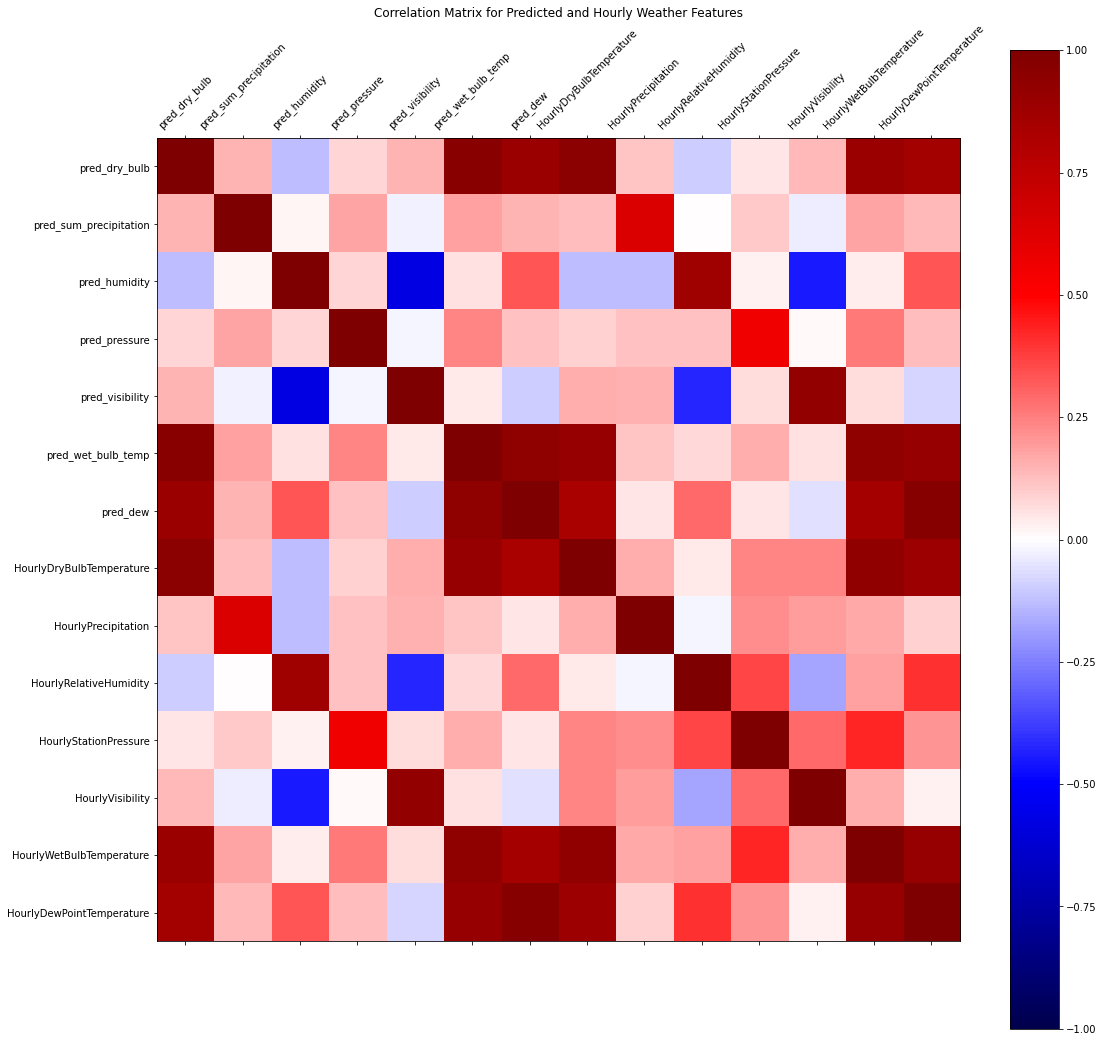

In [0]:
weather_df = spark.read.parquet(f"{blob_url}/weather_feature_engineering_done.v1")

predicted_weather_corr = [
    'pred_dry_bulb', 'pred_sum_precipitation', 'pred_humidity', 'pred_pressure', 'pred_visibility', 'pred_wet_bulb_temp', 'pred_wind_direction', 'pred_wind_gust', 'pred_wind_speed', 'pred_dew',
    'HourlyDryBulbTemperature', 'HourlyPrecipitation','HourlyRelativeHumidity', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed', 'HourlyDewPointTemperature'
] 

plot_samples = ['pred_dry_bulb', 'pred_sum_precipitation', 'pred_humidity', 'pred_pressure', 'pred_visibility', 'pred_wet_bulb_temp',  'pred_dew', 
                'HourlyDryBulbTemperature', 'HourlyPrecipitation','HourlyRelativeHumidity', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyDewPointTemperature'] 

assembler = VectorAssembler(inputCols=plot_samples,
                            outputCol='features')
df = assembler.transform(weather_df)

# get correlation matrix
vector_col = "features"
matrix = Correlation.corr(df, vector_col)
corrmatrix = matrix.collect()[0][0].toArray().tolist()
plot_corr_matrix(corrmatrix, [''] + plot_samples, 234, 'Predicted and Hourly Weather Features')

## Feature Selection

  We used three different approaches for feature selection for different experiments in the modeling portion. Each technique had their own strengths, but ultimately, we used a random forest tree for feature selection. We kept features use the features with importance scores over .0001 from the dedicated random forest model.
  
  The correlation and feature importance approaches both resulted in similar features.
  
  Our initial modeling attempts used features that were selected using features with over .022 correlation with `DEP_DELAY15`. However, the results of modeling experiments were not as impressive as the features selected by the random forest.

### 1. Handpicking Features

  We mainly used our intuition here to choose feature we thought would perform well. This was the most informal method for picking features. We used our intuition and ran calibration experiments, choosing some features over others arbritrarily, but optimizing for weighted precision. However, we realized this was simply "guessing-and-checking" features in a non-systematic way.

### 2. Correlation with `DEP_DELAY`

Since the previous attempt to pick features was not very objective, we wanted to use a programmtic way to determine which features to use for our modeling in the next step. Here, we determined the correlation between our feature engineered columns and our target variable `DEP_DELAY`. 

We first determined the correlation between the pairs of each of our features. At first glance, the noticeable observations are:
- NET_FLOW features are positively correlated amongst themselves, which reflects the relationship that more traffic leads to more delays. =
- NET_FLOW_SQUARED features are negatively correlated amonst themselves.
- PAGERANK_SCORE is negatively correelated with the NET_FLOW and positively correlated with the NET_FLOW_SQUARED
- predicted weather columns are positively correlated amongst themselves, which reflects the nature behind dew point, humidity, pressure, and visibility.

<command-849916349910619>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
 ax.set_yticklabels(attr)
<command-849916349910619>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
 ax.set_xticklabels(attr, rotation=45)

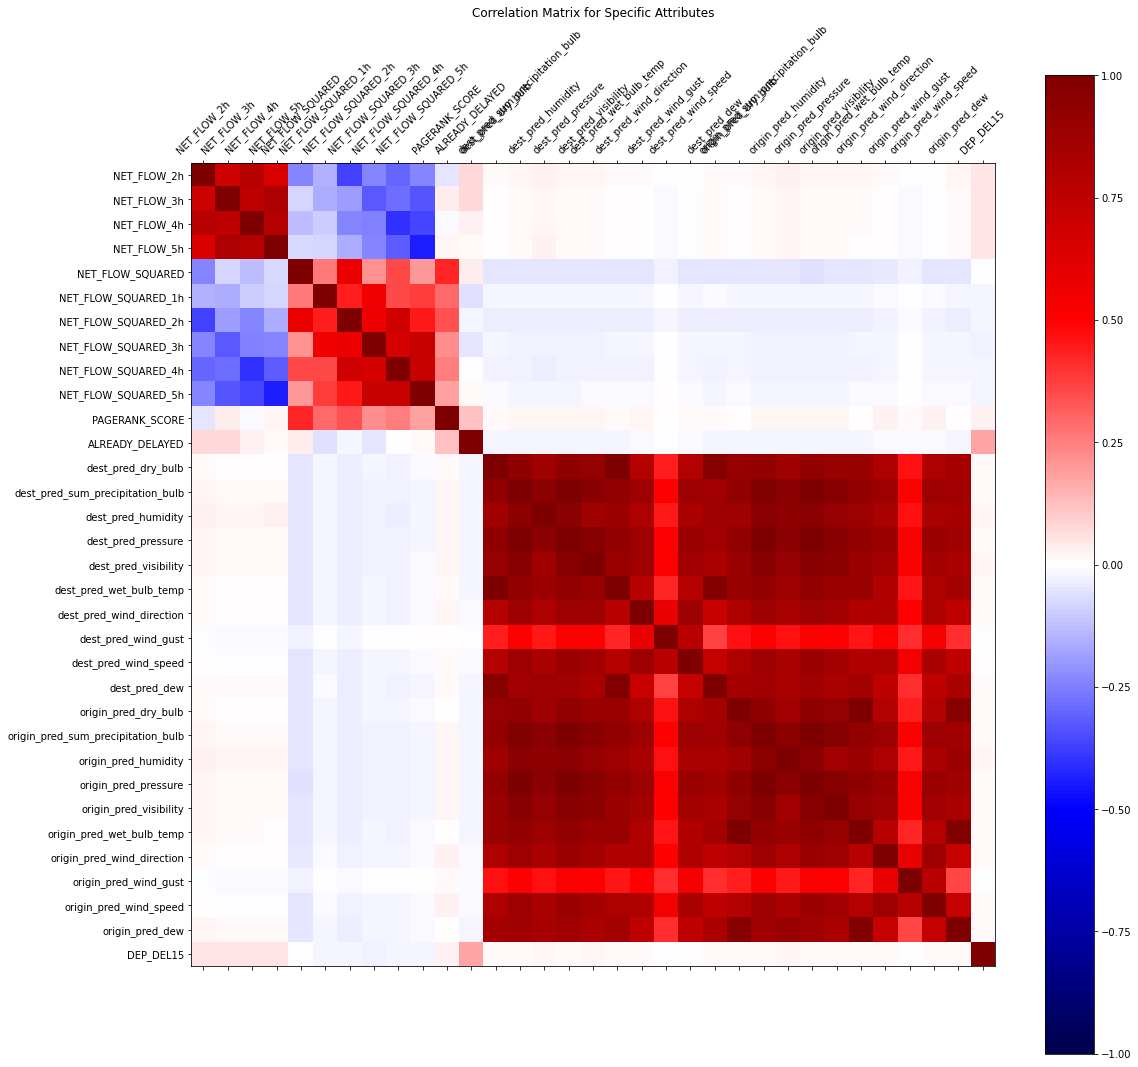

In [0]:
# assemble vector for features from features_column
feature_correlation_df = master_df.drop('features')
feature_correlation_cols = feature_columns + ["DEP_DEL15"]
feature_assembler = VectorAssembler(inputCols=feature_correlation_cols,
                            outputCol='features')
feature_correlation_df = feature_assembler.transform(feature_correlation_df)

# create correlation plot for each of the features
feature_correlation_matrix = Correlation.corr(feature_correlation_df, 'features')
feature_corrmatrix = feature_correlation_matrix.collect()[0][0].toArray().tolist()
plot_corr_matrix(feature_corrmatrix, [''] + feature_correlation_cols, 234) # You can pass in a new chart title as the last arg to this function


feature spearman NET_FLOW_SQUARED_3h -0.024532030299282945 NET_FLOW_SQUARED_5h -0.020908634559199075 NET_FLOW_SQUARED_1h -0.02053441939885914 NET_FLOW_SQUARED_4h -0.018361108826348737 NET_FLOW_SQUARED_2h -0.017038164812174208 dest_pred_wind_gust -0.003393054243436771 NET_FLOW_SQUARED -0.0027504879828781238 origin_pred_wind_gust -0.0012986109931681338 dest_pred_wind_speed 0.006672376233959168 origin_pred_wind_speed 0.008680337175520544 origin_pred_dry_bulb 0.010101738293805621 origin_pred_wet_bulb_temp 0.011238933401731295 origin_pred_dew 0.011890504461157227 dest_pred_dry_bulb 0.012408492901763603 dest_pred_wet_bulb_temp 0.013238280913378673 dest_pred_wind_direction 0.013457975075747204 dest_pred_dew 0.0135438331915825 origin_pred_wind_direction 0.013759028787001354 origin_pred_visibility 0.014119236155729853 origin_pred_pressure 0.014409553822388501 origin_pred_sum_precipitation_bulb 0.014511393092642186 dest_pred_pressure 0.014529675476527611 dest_pred_sum_precipitation_bulb 0.014537921244743878 dest_pred_humidity 0.015920817479663136 dest_pred_visibility 0.01664863014559619 origin_pred_humidity 0.01753015892054378 PAGERANK_SCORE 0.031207086325929907 NET_FLOW_5h 0.04829068091205921 NET_FLOW_2h 0.04987499088216167 NET_FLOW_4h 0.050754689352531926 NET_FLOW_3h 0.05464223759967872 ALREADY_DELAYED 0.1745161361772273 DEP_DEL15 1.0

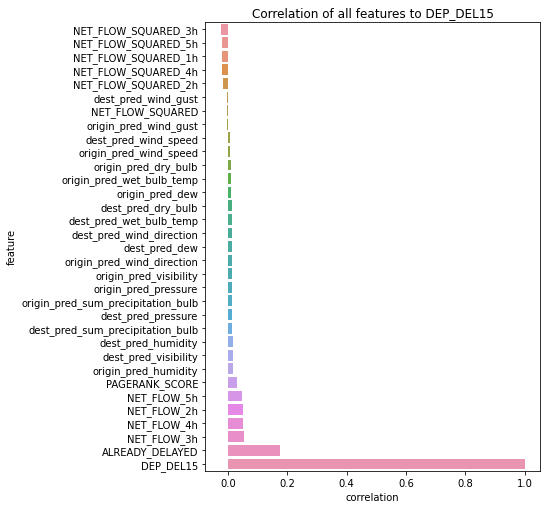

In [0]:
feature_corr_df = pd.DataFrame(feature_correlation_matrix.collect()[0][0].toArray(), columns=feature_correlation_cols, index=feature_correlation_cols)
feature_corr_vis_df = corr_vis(feature_corr_df, feature_correlation_cols)
display(feature_corr_vis_df)

### 3. Random Forest Feature Importance

Once we added our engineered features, we could no longer use our intuition to determine which features were better. Using correlations was also limited because it lacked practcality with an actual model. As a result, we developed a random forest model and used its feature importance scores to determine which features to keep for the experimentation.

For this random forest implementation, we undersampled our data, used grid search, and applied cross validation, optimizing for weighted precision. The grid search parameters searched for the best performing model amongst max trees [10, 30, 50] and max depth[5, 15, 25]. This was also a dryrun for us to test out our modeling pipeline and determine the features we would ultimately use.

### Final Feature Set Description

|Feature| Description|
|---|---|
|FLOW_RATIO| Number of depating / number of arriving flights|
|FLOW_RATIO_1h|Number of depating / number of arriving flights 1 hour window|
|FLOW_RATIO_2h|Number of depating / number of arriving flights 2 hour window|
|FLOW_RATIO_3h|Number of depating / number of arriving flights 3 hour window|
|FLOW_RATIO_4h|Number of depating / number of arriving flights 4 hour window|
|FLOW_RATIO_5h|Number of depating / number of arriving flights 5 hour window|
|NET_FLOW_SQUARED|The net difference in incoming and outgoing flights from the same airport within the same hour, squared|
|NET_FLOW_SQUARED_1h|The net difference in incoming and outgoing flights from the same airport within a 1 hour window, squared|
|NET_FLOW_SQUARED_2h|The net difference in incoming and outgoing flights from the same airport within a 2 hour window, squared|
|NET_FLOW_SQUARED_3h|The net difference in incoming and outgoing flights from the same airport within a 3 hour window, squared|
|NET_FLOW_SQUARED_4h|The net difference in incoming and outgoing flights from the same airport within a 4 hour window, squared|
|NET_FLOW_SQUARED_5h|The net difference in incoming and outgoing flights from the same airport within a 5 hour window, squared|
|PAGERANK_SCORE|Graph based feature calculating airport importance by total number of flights connecting to each airport|
|ALREADY_DELAYED|Score between 0-5 capturing if the prior flight departure was already delayed|
|dest_pred_dry_bulb|Predicted dry bulb temperature at destination airport at time of departure|
|dest_pred_sum_precipitation_bulb|Predicted hourly precipitation at the expected flight departure at the destination airport.|
|dest_pred_humidity|Predicted humidity destination airport at time of departure |
|dest_pred_pressure|Predicted air pressure at destination airport at time of departure|
|dest_pred_visibility|Predicted visibility at destination airport at time of departure|
|dest_pred_wet_bulb_temp|Predicted wet bulb temperature at destination airport at time of departure|
| dest_pred_wind_direction|Predicted wind direction at destination airport at time of departure|
| dest_pred_wind_gust|Predicted wind gust presence at destination airport at time of departure|
| dest_pred_wind_speed|Predicted wind speed at destination airport at time of departure|
| dest_pred_dew|Predicted dew point at destination airport at time of departure|
| origin_pred_dry_bulb|Predicted dry bulb temperature at origin airport at time of departure|
| origin_pred_sum_precipitation_bulb|Predicted hourly precipitation at the expected flight departure at the origin airport.|
| origin_pred_humidity|Predicted humidity origin airport at time of departure |
| origin_pred_pressure|Predicted air pressure at origin airport at time of departure|
| origin_pred_visibility|Predicted visibility at origin airport at time of departure|
| origin_pred_wet_bulb_temp|Predicted wet bulb temperature at the origin airport at time of departure|
| origin_pred_wind_direction|Predicted wind direction at origin airport at time of departure|
| origin_pred_wind_gust|Predicted wind gust presence at origin airport at time of departure|
| origin_pred_wind_speed|Predicted wind speed at origin airport at time of departure|
| origin_pred_dew|Predicted dew point at origin airport at time of departure|

# Model Pipeline / Preparation

In our model pipeline, we implemented undersampling, grid search and cross validation to optimize for weighted average. This pipeline allowed us to easily train multiple models using the same template code.

Using the joined dataset, we engineered features as state previously. Once the features were merged back with the Joined dataset to create a master dataset, we created a template pipeline that would prepare the data for model training. The pipeline consisted of:
1. Splitting up the training (years 2015 - 2019) and Testing (2021) data
2. Undersampling
3. Parameter Grid Search
4. 5 Fold Cross Validation

Once the model preparation was done, different models in our experiment were trained and evaluated. While we prioritized Weighted Precision, we still show the values of other evaluation metrics, including precision, recall, f1 score, and weighted recall. We also recorded the confusion matrices for each year.

The pipeline can be consolidated into this figure:

![Model Pipeline](https://raw.githubusercontent.com/JustinRWong-mids/public-images/main/model-pipeline.png)

## Grid Search

Since machine learning models have several hyper parameters which need to be modified to get the best result for given dataset,  we leverage GridSearch as a tuning method to attempt to compute the optimized values of hyperparameters for predicitng Departure delay. It is exhaustive search performed on the specific parameter values of a model(also known as estimator).

As the models can give different result for different paramters it was important that we train and validate the models on several subsets to know that the best parameters are improving performance on all the subsections of data so it's not just a lucky hit.

## Cross Validation

We used Cross Validation(CV) technique to assess the performance on the mutliple subsets of training and testing data. 

Our Cross-Validation steps has two main steps:
- splitting the data into subsets (called folds)
- rotating the training and validating among them.

Our splitting technique has the following properties:

1. Each fold has approximately the same size of our training data.
2. Data can be randomly selected in each fold or stratified.
3. All folds are used to train the model except one, which is used for validation. That validation fold should be rotated until all folds have become a validation fold once and only once.
4. Each example is recommended to be contained in one and only one fold.

Cross Validation and Grid Search usually work together to tune the best set of parameters for given dataset and estimators. For our use case we chose **`WeightedPrecision` as the model evaluation metrics** to pick the best hyperparameters while performing CV.

We performed on the training sets using Xgboost as the base model. The **Max depth**, which indicates the depth of the tree, happened to be the most important parameter to tune. 5 folds crossValidation and addGrid (xgb.max_depth, [2,5,10]). Once the Gridsearch model was ready, we trained it on our model.

This resulted in an improvement in the weighted precision. The overall results with XGBoost were in general way better than other modelling techniques we tried.

## Undersampling
As most of the times flights will not have departure delays we get **class imbalances** due to this. So in order to have equal number of classes(class 0,1) we are computing the ratio of zeroes in training dataset for each year and downsample the class 0 to match the number of samples to class 1.

## Example Model Pipeline Code

In [0]:

def capture_feature_imp_dict(gain_values, predictions):
    index = [int(i[1:]) for i in gain_values.keys()]
    save_features = {}
    for i in predictions.schema['features'].metadata['ml_attr']['attrs']['numeric']:
        save_features[i['idx']] = i['name']
    # for i in predictions.schema['features'].metadata['ml_attr']['attrs']['binary']:
    #     save_features[i['idx']] = i['name']

    feature_imp_dict = {}
    for n, i in enumerate(index):
        old_feat_ind = 'f' + str(i)
        feature_imp_dict[save_features[i]] = gain_values[old_feat_ind]
    return feature_imp_dict

## Initializing model pipeline
df = spark.read.parquet(f"{blob_url}/master.v4")
df = df.withColumn("ALREADY_DELAYED", df["ALREADY_DELAYED"].cast(IntegerType())).na.fill(value = -1)

feature_columns =['NET_FLOW_2h',
 'NET_FLOW_3h',
 'NET_FLOW_4h',
 'NET_FLOW_5h',
 'NET_FLOW_SQUARED',
 'NET_FLOW_SQUARED_1h',
 'NET_FLOW_SQUARED_2h',
 'NET_FLOW_SQUARED_3h',
 'NET_FLOW_SQUARED_4h',
 'NET_FLOW_SQUARED_5h',
 'PAGERANK_SCORE',
 'ALREADY_DELAYED',
 'dest_pred_dry_bulb',
 'dest_pred_sum_precipitation_bulb',
 'dest_pred_humidity',
 'dest_pred_pressure',
 'dest_pred_visibility',
 'dest_pred_wet_bulb_temp',
 'dest_pred_wind_direction',
 'dest_pred_wind_gust',
 'dest_pred_wind_speed',
 'dest_pred_dew',
 'origin_pred_dry_bulb',
 'origin_pred_sum_precipitation_bulb',
 'origin_pred_humidity',
 'origin_pred_pressure',
 'origin_pred_visibility',
 'origin_pred_wet_bulb_temp',
 'origin_pred_wind_direction',
 'origin_pred_wind_gust',
 'origin_pred_wind_speed',
 'origin_pred_dew']
df = df.drop('features')

# feature selection
assembler = VectorAssembler(inputCols=feature_columns,
                            outputCol='features')
df = assembler.transform(df)
train_df = df.where(df.YEAR <= 2020)
test_df = df.where(df.YEAR == 2021)


from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#Train/Validation/Test Split
yearly_precision = []
yearly_recall = []
yearly_F1 = []
xgb_models_list = []
xgb_feature_importances = []
xgb_metrics_list = []
xgb_confusion_matrices = []

# years = [2018]
years = [2015, 2016, 2017, 2018, 2019]

# Model definiotin
xgb = XgboostClassifier(featuresCol = 'features', labelCol = 'DEP_DEL15')
for year in years:
    train = train_df.where(train_df.YEAR == year)
    val = train_df.where((train_df.YEAR == year+1) & (train_df.QUARTER == 1))
    
    # balance data set
    # get number of delayed flights
    num_0 = train.filter(train.DEP_DEL15==0).count()
    # calculate the sub-sampling ratio for the on-time flights
    ratio = (train.count() - num_0)/num_0
    # under sample the redundant class
    train = train.sampleBy('DEP_DEL15', {0: ratio, 1:1}, seed = year)
    print("Year = %s" % (year))
    print('num_0 = %s' % (num_0))
    print('Ratio = %s' % (ratio))
    # grid search
    paramGrid = ParamGridBuilder()\
                .addGrid(xgb.max_depth, [2,5,10])\
                .build()
                #.addGrid(rf.maxBins, [5,10,20])\
                #.addGrid(rf.numTrees, [5,20,50])\
    pipeline = Pipeline(stages=[xgb])
    xgbevaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='DEP_DEL15', metricName='weightedPrecision')
    
    # Cross validation
    xgbcv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=xgbevaluator,
                          numFolds=5)
    xgbModel = xgbcv.fit(train)
    predictions = xgbModel.transform(val)
    
    # Model Evaluation
#     predictions.select(cols).show(25)
    feature_importance = capture_feature_imp_dict(xgbModel.bestModel.stages[-1].get_booster().get_score(importance_type="gain"), predictions)
    labels_and_predictions = predictions.select(col('prediction'),col('DEP_DEL15')).withColumnRenamed('DEP_DEL15','label').rdd
    labels_and_predictions = labels_and_predictions.map(lambda x: (x['prediction'],x['label']))
    evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol = 'prediction')
    metrics = MulticlassMetrics(labels_and_predictions)
    weightedPrecision = metrics.weightedPrecision
    weightedRecall = metrics.weightedRecall
#     accuracy = evaluator.evaluate(predictions)
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1_score = metrics.fMeasure(1.0)
    yearly_precision.append(precision)
    yearly_recall.append(recall)
    yearly_F1.append(f1_score)
#     print("Year = %s" % (year))
    xgb_models_list.append(xgbModel)
    xgb_feature_importances.append(feature_importance)
    xgb_metrics_list.append(metrics)
    xgb_confusion_matrices.append(metrics.confusionMatrix())
    pretty_print(year, num_0, ratio, metrics)
    
    for k, v in feature_importance.items():
        if v > .005:
            print(f"{k} : {(v*100):.{3}}")
#     print("Test Error = %s" % (1.0 - accuracy))
    print('--------------')

# Modeling

We looked at several different modelin algorithms throughout this project. We set a baseline with a Linear Regression model, but quickly moved on to more complex models.
<br>
<br>

1) Random Forest
2) XGBoost
3) Single-Layer Perceptron
4) Multi-Layer Neural Network

For a detailed look at our models, please visit our detailed [modeling notebook](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/849916349902929/command/849916349902930). The results have been consolidated into [this spreadsheet](https://docs.google.com/spreadsheets/d/1mORlGw3J0EDWyneeun_txVCnvbTaTnI0kb38BQMAUJ4/edit#gid=623804780).
<br>

To look at our model evaluation against only the held out set, please see the [2021 Evaluation Modeling Notebook](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/849916349914481/command/849916349914619).

We used 5-fold blocked time series cross validation to evaluate our model performance and parameters. Each training set consisted of a full years data and validated against the following years Q1 data. <br> 

<br><img src='https://github.com/ssshahbuddin/w261_FP/blob/main/Blocking_Time_Series_Split.jpg?raw=true' width = 30% align = 'center'>

## Training Experiments

Below are the results of our training experiments. We ran a few calibration experiments using random forest initially as we were still finalizing features to keep. Our feature selection process was previously discussed above.

Below are the results of our experiment runs. The calibration experiments consist of handpicked features.

### Calibration Experiments
|Algorithm|# Features|Algorithm Description|Training Time|Year|num_0|Ratio|Precision|Recall|F1-Score|Weighted Precision|Weighted Recall|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Random Forest|16|Baseline Random Forest model to add more features|8.16 minutes|2015|4661886|0.2442494304|0.2729056041|0.5488725708|0.3645519072|0.7707032899|0.6883957883|
|             |16||8.16 minutes|2016|4585196|0.2206130338|0.3105744364|0.5477570133|0.3963954152|0.7532817024|0.6925579749|
|             |16||8.16 minutes|2017|4565048|0.2380962916|0.2952869226|0.554444456|0.3853457723|0.7460167097|0.6832974316|
|             |16||8.16 minutes|2018|5773283|0.2455093575|0.3057033536|0.5711860534|0.398256589|0.7394600265|0.6738133702|
|             |16||8.16 minutes|2019|5909803|0.2513041467|0.2004011256|0.5167566099|0.2888028705|0.7251266627|0.6605120198|
|Random Forest|22|Added more` NETFLOW` and `FLOW_RATIO` columns to see if a bigger window would capture delays better|7.35 minutes|2015|4661886|0.2442494304|0.2302369369|0.6376558533|0.3383181244|0.7652026274|0.5977695062|
|             |22||7.35 minutes|2016|4585196|0.2206130338|0.2650559788|0.6139637945|0.3702641953|0.7451836504|0.6190807313|
|             |22||7.35 minutes|2017|4565048|0.2380962916|0.2719825694|0.5999730293|0.3742901734|0.7445046296|0.6445753874|
|             |22||7.35 minutes|2018|5773283|0.2455093575|0.2732095048|0.6230001333|0.3798431766|0.7337222071|0.6191504358|
|             |22||7.35 minutes|2019|5909803|0.2513041467|0.1685743489|0.5918170405|0.2624047922|0.715413478|0.5711510461|
|Random Forest|17|Handpicked features to ignore possible overlap|10.23 minutes|2015|4661886|0.2442494304|0.2729056041|0.5488725708|0.3645519072|0.7707032899|0.6883957883|
|             |17||10.23 minutes|2016|4585196|0.2206130338|0.3105744364|0.5477570133|0.3963954152|0.7532817024|0.6925579749|
|             |17||10.23 minutes|2017|4565048|0.2380962916|0.2952869226|0.554444456|0.3853457723|0.7460167097|0.6832974316|
|             |17||10.23 minutes|2018|5773283|0.2455093575|0.3057033536|0.5711860534|0.398256589|0.7394600265|0.6738133702|
|             |17||10.23 minutes|2019|5909803|0.2513041467|0.2004011256|0.5167566099|0.2888028705|0.7251266627|0.6605120198|

### Experiments with Correlation Feature Selection Technique
|Algorithm|# Features|Algorithm Description|Training Time|Year|num_0|Ratio|Precision|Recall|F1-Score|Weighted Precision|Weighted Recall|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Random Forest|18|This approach uses an objective, systematic approach to feature selection using correlation with the y variable. The features here have correlations over .15 with DEP_DELAY15|9.44 minutes|2015|4661886|0.2442494304|0.2313401523|0.6348714948|0.3391117374|0.7653167893|0.6008059442|
|             |18||9.44 minutes|2016|4585196|0.220613033|0.2575057365|0.634800786|0.3663871994|0.7447007269|0.6004280719|
|             |18||9.44 minutes|2017|4565048|0.2380962916|0.272035394|0.5889288839|0.3721629458|0.7430583749|0.6476196251|
|             |18||9.44 minutes|2018|5773283|0.2455093575|0.2717144606|0.624142461|0.3786062886|0.7331994685|0.616562322|
|             |18||9.44 minutes|2019|5909803|0.2513041467|0.1733528517|0.5730507617|0.2661830193|0.7162323982|0.5896116949|
|XGBoost|18|Grid search over xgb.max_depth=[2,5,10]|2.25 hours|2015|4661886|0.2442494304|0.2802846061|0.5705386554|0.3759022808|0.7740012483|0.6901820597|
|             |18||2.25 hours|2016|4585196|0.2206130338|0.3127431139|0.5801705757|0.4064096106|0.7584672434|0.6882177604|
|             |18||2.25 hours|2017|4565048|0.2380962916|0.297884785|0.5688149846|0.3910035178|0.7482577971|0.6825580074|
|             |18||2.25 hours|2018|5773283|0.2455093575|0.3154246827|0.5730042583|0.4068748282|0.741949271|0.6828296175|
|             |18||2.25 hours|2019|5909803|0.2513041467|0.2151344426|0.5364644818|0.3071105706|0.7192661441|0.6647962246|
|Single Layer Hidden Layer Perceptron Neural Net|18|layers = [len(feature_columns) input,5 sigmoid, 3 softmax output], trained on 100 epochs|5.10 minutes|2015|4661886|0.2442494304|0|0|0|0.6813484226|0.8254383215|
|             |18||5.10 minutes|2016|4585196|0.2206130338|0|0|0|0.6479335615|0.8049432039|
|             |18||5.10 minutes|2017|4565048|0.2380962916|0|0|0|0.6460055252|0.8037446891|
|             |18||5.10 minutes|2018|5773283|0.2455093575|0.2185239915|0.7986520533|0.3431552196|0.7280823403|0.4386683573|
|             |18||5.10 minutes|2019|5909803|0.2513041467|0|0|0|0.6663158689|0.8162817338|
|Multiple Layer Hidden Layer Perceptron Neural Net|18|layers = [len(feature_columns) input,10 sigmoid, 6 sigmoid, 3 softmaxoutput], trained on 100 epochs|5.26 minutes|2015|4661886|0.2442494304|0.11360799|0.0004294519061|0.0008556692791|0.6992486744|0.8249841216|
|             |18||5.26 minutes|2016|4585196|0.2206130338|0|0|0|0.6479335615|0.8049432039|
|             |18||5.26 minutes|2017|4565048|0.2380962916|0|0|0|0.6460055252|0.8037446891|
|             |18||5.26 minutes|2018|5773283|0.2455093575|0|0|0|0.63077632|0.7942142784|
|             |18||5.26 minutes|2019|5909803|0.2513041467|0|0|0|0.6663158689|0.8162817338|

### Experiments using Random Forest Selected Features

These experiments included Cross Validation. Grid Search was applied for the Random Forest and XG Boost algorithms.
|Algorithm|# Features|Algorithm Description|Training Time|Year|num_0|Ratio|Precision|Recall|F1-Score|Weighted Precision|Weighted Recall|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Random Forest|32|This approach uses an objective, systematic approach to feature selection using the important features from a random forest model over a set threshold of.0001.|11.43 minutes|2015|5960225|5960225|0.5220703171|0.2112101105|0.3007485955|0.7839383465|0.8290056522|
|             |32||11.43 minutes|2016|4585196|0.2206130338|0.3120686189|0.3893975501|0.3464707523|0.7346043828|0.7256599194|
|             |32||11.43 minutes|2017|4565048|0.2380962916|0.317152905|0.3763826793|0.3442386024|0.7303482054|0.7355528226|
|             |32||11.43 minutes|2018|5773283|0.2455093575|0.3100196378|0.4052597844|0.3512990523|0.7193798295|0.7111468962|
|             |32||11.43 minutes|2019|5909803|0.2513041467|0.2605547104|0.3113112972|0.2836805259|0.7159055231|0.7586186087|
|XGBoost|18|Grid search over xgb.max_depth=[2,5,10]|2.25 hours|2015|5960225|0.2818962371|0.3016985946|0.4564932184|0.3632942484|0.7659031443|0.7344873982|
|             |18||2.25 hours|2016|4585196|0.2206130338|0.3106187144|0.5558969857|0.3985432856|0.7535025357|0.6901826073|
|             |18||2.25 hours|2017|4565048|0.2380962916|0.2904145368|0.538265509|0.3772749911|0.7401174248|0.6797934086|
|             |18||2.25 hours|2018|5773283|0.2455093575|0.3134044264|0.5428404612|0.3973830521|0.7359872428|0.6857130732|
|             |18||2.25 hours|2019|5909803|0.2513041467|0.2115244984|0.5104043697|0.2990960275|0.7147286324|0.666158458|
|Single Layer Hidden Layer Perceptron Neural Net|18|layers = [len(feature_columns) input,5 sigmoid, 3 softmaxoutput], trained on 100 epochs|11.92 minutes|2015|5960225|0.2818962371|0.2020929448|0.4492161323|0.2787721351|0.7325232885|0.6219977201|
|             |18||11.92 minutes|2016|4585196|0.2206130338|0.2054319331|0.7885781178|0.3259506823|0.7306269832|0.4137601756|
|             |18||11.92 minutes|2017|4565048|0.2380962916|0.2640518441|0.2906539697|0.2767150255|0.7076030992|0.7194244265|
|             |18||11.92 minutes|2018|5773283|0.2455093575|0.2274609343|0.562168011|0.323876833|0.7003893037|0.5609198843|
|             |18||11.92 minutes|2019|5909803|0.2513041467|0.1838470389|0.3113862499|0.2311938284|0.6960743214|0.6989129564|
|Multiple Layer Hidden Layer Perceptron Neural Net|18|layers = [len(feature_columns) input,10 sigmoid, 6 sigmoid, 3 softmax output], trained on 100 epochs|6.70 minutes|2015|5960225|0.2818962371|0.1928096127|0.3801451642|0.2558514034|0.7246906918|0.6394278273|
|             |18||6.70 minutes|2016|4585196|0.2206130338|0.2221856921|0.5537773318|0.3171321208|0.714901437|0.5655494358|
|             |18||6.70 minutes|2017|4565048|0.2380962916|0.208345091|0.5539984025|0.3028106059|0.7062262225|0.5510452903|
|             |18||6.70 minutes|2018|5773283|0.2455093575|0.2182381933|0.5985543209|0.3198545807|0.698789171|0.5268557659|
|             |18||6.70 minutes|2019|5909803|0.2513041467|0.1439944324|0.5253340079|0.2260330437|0.697183202|0.5388623294|

# Evaluation Metrics Comparison

We can get feature score for each individual feature in XGBoost model. This helps us understanding what is the contribution of individual feature in final model and what their feature rank is overall.

After each of out modeling experiments, we only present the final feature set (32 features via the random forest selection process) below for brevity.

Each of the evaluation runs used 2015 - 2020 as the training data and was tested on 2021. The modeling work was done in [this notebook](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/849916349914481/command/849916349914489)


|Algorithm|Time|Precision|Recall|Weighted Precision|Weighted Recall|
|:-:|:-:|:-:|:-:|:-:|:-:|
|Random Forest|8.68 minutes|0.456|0.269|0.764|0.806|
|XG Boost|31.60 minutes|0.446|0.267|0.762|0.803|
|Single Hidden Layer Multilayer Perceptron Neural Network|5.85 minutes|0.35|0.287|0.743|0.773|
|Multiple Hidden Layer Multilayer Perceptron Neural Network|8.24 minutes|0.224|0.494|0.725|0.612|

### Model Details

The final model details are presented below using the full 32 column feature set. The Feature Importances only make sense in context of explanable models, such as Random Forest and XG Boost. However, for the neural nets, we can only provide their architectures, since neural nets are black box algorithms.

#### Random Forest Feature Importance
|Feature| Importance(%)|Feature|Importance(%)|
|---|---|---|---|
|NET_FLOW_2h|0.0|dest_pred_pressure|0.408|
|NET_FLOW_3h|0.0|dest_pred_visibility|0.416|
|NET_FLOW_4h|0.00969|dest_pred_wet_bulb_temp|0.432|
|NET_FLOW_5h|0.0107| dest_pred_wind_direction|0.482|
|NET_FLOW_SQUARED|0.0274| dest_pred_wind_gust|0.659|
|NET_FLOW_SQUARED_1h|0.0515| dest_pred_wind_speed|0.691|
|NET_FLOW_SQUARED_2h|0.0863| dest_pred_dew|0.714|
|NET_FLOW_SQUARED_3h|0.111| origin_pred_dry_bulb|0.757|
|NET_FLOW_SQUARED_4h|0.12| origin_pred_sum_precipitation_bulb|1.01|
|NET_FLOW_SQUARED_5h|0.203| origin_pred_humidity|1.72|
|PAGERANK_SCORE|0.264| origin_pred_pressure|1.85|
|ALREADY_DELAYED|0.299| origin_pred_visibility|4.27|
|dest_pred_dry_bulb|0.38| origin_pred_wet_bulb_temp|4.42|
|dest_pred_sum_precipitation_bulb|0.402| origin_pred_wind_direction|4.83|
|dest_pred_humidity|0.407| origin_pred_wind_gust|4.92|
| origin_pred_wind_speed|4.96| origin_pred_dew|65.1|

### XG Boost Feature Gain

#### Feature Importance
|Feature| Information Gain |Feature| Information Gain
|---|---|---|---|
|NET_FLOW_2h|177|dest_pred_pressure|0|
|NET_FLOW_3h|119|dest_pred_visibility|0|
|NET_FLOW_4h|155|dest_pred_wet_bulb_temp|0|
|NET_FLOW_5h|168| dest_pred_wind_direction|0|
|NET_FLOW_SQUARED|127| dest_pred_wind_gust|0|
|NET_FLOW_SQUARED_1h|116| dest_pred_wind_speed|0|
|NET_FLOW_SQUARED_2h|106| dest_pred_dew|0|
|NET_FLOW_SQUARED_3h|412| origin_pred_dry_bulb|0|
|NET_FLOW_SQUARED_4h|146| origin_pred_sum_precipitation_bulb|0|
|NET_FLOW_SQUARED_5h|130| origin_pred_humidity|0|
|PAGERANK_SCORE|187| origin_pred_pressure|0|
|ALREADY_DELAYED|335| origin_pred_visibility|0|
|dest_pred_dry_bulb|0| origin_pred_wet_bulb_temp|0|
|dest_pred_sum_precipitation_bulb|0| origin_pred_wind_direction|0|
|dest_pred_humidity|0| origin_pred_wind_gust|0|
| origin_pred_wind_speed|0| origin_pred_dew|0|

### Single Hidden Layer Multilayer Perceptron Neural Network

The single hidden layer architecture was fairly simple and included:
- 32 input columns
- 5 sigmoid neurons hidden layer
- 3 softmax output layer

|Layer|Description|
|---|---|
|Features| 32|
|Num Layers| 3|
|Num Classes| 3 |

### Multiple Hidden Layer Multilayer Perceptron Neural Network

The multiple hidden layer had one extra layer with the following architecture:
- 32 input columns
- 10 sigmoid neurons hidden layer
- 6 sigmoid neurons hidden layer
- 3 softmax output layer

|Layer|Description|
|---|---|
|Features| 32|
|Num Layers| 4|
|Num Classes|3 |

# Discussion and Key Findings

### Experiment Analysis

We implemented multiple iterations of our training experiments. During the training process, we did not consider early stopping conditions because training time for our Random Forest and Neural Nets were already fast. However, this would've been suitable for the XG Boost model because training this particular took hours.

We also attempted multiple variations of features that were included in each training experiment set. We performed 12 experiments in total. Ultimately, the features with the best performance included 32 features. Typically, as we added newly engineered feautres, performance improved, suggesting our features were useful in predicting flight delays. We were able to optimize for weighted preicsion this way.

Between the baseline and the 18 features, there was a neglible effect of the 16 and 18 column experiments. This is probably because there isn't much difference between adding the net flow within the same and the net flow in a 3 hour window, since the total number of scheduled flights would still be the same.

Once we added the predicted weather features, our weighted precision increased about 1% on average across all the algorithms.

Compared to other teams on the leaderboard, our results were comparable as we were in the high 70s for weighted precision. Many other teams implemented logistic regression, while we used random forest as our primary baseline classifier. In terms of developed features, we captured our own variation of features our peers used. Many attempted to capture previously delayed flights, weather around the time of flights, and pagerank. Our versions were the `ALREADY_DELAYED` and our predicted weather columns. Our net flow of flights seemed to be one of the more unique features.

Comparing our model performances, different models appear to have different strengths. For example, the tree based algorithms had higher precision, while the neural nets had higher recall. We also found it intersting that 2015 tended to have slightly better precision than the later years 2016 - 2019. We were expecting the XG Boost method to perform better because XGBoost always gives more importance to functional space when reducing the cost of a model while Random Forest tries to give more preferences to hyperparameters to optimize the model. Our features attempted to create a realistic model of the world that's relevant for flight delays, such as congested traffic at airports and bad weather, which led us to believe the functional space would've improved. However, random forest was still better at minimizing its loss function.

### Summary
Our experiments are summarized below:

#### Algorithms:
- Random Forest
- XG Boost
- Single hidden layer Multilayer Perceptron (input, 5 sigmoid, 3 softmax output) Neural Network
- Single hidden layer Multilayer Perceptron (input, 10 sigmoid, 6 sigmoid, 3 softwax output) Neural Network.

#### Techniques:
- Cross Validation
- Grid Search for XG Boost
- 100 Epochs for MLP

#### Metrics:
- Precision
- Recall
- F1 Score
- Weighted Precision (priority)
- Weighted Recall

#### Input Feature Variations
- 16 Features (baseline with 3 hour windowed `NET_FLOW_SQUARED`, `FLOW_RATIO`, and `ALREADY_DELAYED`)
- 18 Features (with 6 hour windowed `NET_FLOW_SQUARED`, `FLOW_RATIO`, and `ALREADY_DELAYED`)
- 22 Features (Windowed `NET_FLOW_SQUARED` and `FLOW_RATIO`, and `ALREADY_DELAYED`)
- 32 Features (Windowed `NET_FLOW_SQUARED` and `FLOW_RATIO`, `ALREADY_DELAYED`, and predicted weather columns)

#### Final Results
| Algorithm | Weighted Precision(%) | Weighted Recall(%)| Time(m) | 
|:-:| :-: |:-:|:-:|
|Random Forest| 76.4 | 80.6 |8.68|
|XG Boost | 76.2| 80.3|31.60|
|Single-Layer NN| 74.3|77.3|5.58|
|Multi-Layer NN| 72.5|61.2|8.24|

## Novel Approaches and Techniques

### Modeling
The Random Forest model provded the best results in terms of the F1 score which is the harmonic mean of Precision and Recall with the weighted F1 result at 78.4%. This model could serve well for both airlines looking to identify which flights may be delayed in order to adjust staffing needs or to notify end users that their flight would likely be delayed. Ideally, for the latter use case, a higher precision model would be available. 



For airlines looking for a higher detection rate of flights that would be delayed, the Multilayer Neural Network provided a marginally higher recall than the Random Forest Model and XG Boost, albeit at the cost of more false positives resulting in lower precision. 

Airlines could use an ensemble approach utilizing the Neural Net and the Random Forest together to see which flights the two models disagreed on. This combination approach in the investigation could lead to better overall model, and, perhaps, for those that appeared in the margins of these models, the flights could be passed to a third model could be used to increase overall precision and recall. We did not have the time to explore this option, but find it to be a natural next step should we continue our analysis.

### Preventing Leakage

Leakage is any data leakage that would not follow the 2 hour before flight information requirements, or anything that would give up the delay such as if we included the actual departure time. This would effectively vie us the departure delay with 100% precision.

To prevent this, we made sure we never used any of the actual departure times columns in our feature engineering work. While developing the net flow feature, the scheduled departing and arriving flight times are treated as fixed, even if the flight was ultimately cancelled. While developing the `ALREADY_DELAYED` column, we lagged our features and have multiple validations, discussed previously, to make sure the feature does not break any cardinal sins of ML. Finally, the predicted weather features simply created linear regression models of the weather. Instead of using the immediate weather at the same hour of a flight, which could be data leakage, we used our predicted weather features as a proxy for these features; we don't incorporate data that is within 2 hours of flight delay. By using our prediction, we made a "second-best guess" toward the effect of weather on flight delays.

### Feature Engineering

#### Net Flow

Congestion at an airport with too many expected arrivals or departures can certainly lead to a backlog. Whether it's excessive departures causing a delay in taxi out time or too many arrivals increasing taxi in time to an available gate, understanding the relationship of what's happening at an airport at any given time can translate into better delay detection. The balance between these two is also critical as air traffic control needs to account for all flights from the aspect of safety and control rather than prioritizing the expected departure times. The human component of managing the air traffic control resources can influence a flight's ability to leave on time. Not to mention, an influx of flights can result in potential gate changes which adds the component of moving passengers and crew to a new gate for the flight. Having this information too close to the expected departure time will undoubtedly lead to additional delays.


Additionally, looking at the net flow throughout the day allows us to observe a cascading effect on flight traffic later in the day. This is a similar pattern to what we saw in our Flights EDA, where flights are affected by previous flights. By capturing this pattern, we will later saw how this feature splays an important role for the model feature importances.

We went a step further and wanted to understand how congestion was changing over time. Looking at not just the expected congestion 2 hours prior to the flight, but the net flow of congestion 3-5 hours before. An interesting next step would be to model on these data points to predict the congestion at the time of the flight itself. We saw this work well with weather predictions, extending this to the Net Flow would ideally provide a similar uplift.

#### Flow Ratio

This proportion takes inspiration [Little's Law (`L = λ W`) in queueing theory](https://en.wikipedia.org/wiki/Little%27s_law). To contextualize this for our flight data, `L` is the total number of flights at an airport during a given hour, `λ` is the rate at which flights can be processed in an airfield, and `W` is the wait time, or time needed for the airport to process a flight. From our previous EDA, delays appear to originate from high magnitude net flows.
  
Assuming each flight takes the same amount of time (`λ`) and a fixed number of flights (`L`), the delays (`W`) still remains the same. `L` is the sum of incoming and outgoing flights, which is constant at an airport in a given hour. Treating `W` as a proxy for departure delays, queueing theory tells us `FLOW_RATIO` would not be important in changing `W` wait times at an airport.

This was counterintuitive because we initially believed the ratio on incoming and outgoing flights may have some effect on departure delays. However, our feature selection process via the random forest tree eliminated `FLOW_RATIO` from the top most important features, echoing the analysis here about this feature.

The takeaway here is that the only way to reduce flight delays (`W`), is by increasing flight processing time or decreasing the total flights in a given hour. In relation to the business problem, this means flights should be spread out evenly throughout the day, instead of having peak hours of the day for flight times. Since Flow Ratio is proven to not be an important factor in reducing delays, airports should focus resources on processing flights quicker, whether it be reduced taxi in or taxi out times, or reduce the total combined flights coming in or out of an airport in a given hour. These factors are relatively more controllable than weather and mechanical breakdowns, which already have upper bound limits on how much they can improve.

#### PageRank

Looking at the data as a network graph with airports as the nodes and the edges taking on the probability of a flight connecting between two airports provided an interesting data point for our models. These datapoints likely play a role in the overall congestion metrics as well as helping our model understand probabilities of connections between origins and destinations with delays. An augmentation to this feature would be to aggregate prior delays across the nodes over the year, quarter, and month timeframe so the model may have an additional data element to determine likelihood of delay at a given flightplan.

#### Cascading Delays

Looking at the effect of prior delays in the day was an obvious direction that many of our peers also landed on. Discovering pyspark's window and lag functions provided clear direction on how to capture the metric. While we worked on creating other features, the cascading delay feature helped improve our model drastically and continued to play an important role in the determination of a flight delay. Extending this logic to arrival delays might also help improve model detection.

#### Predicting weather

One feature we did not see appear in other teams significant features was modeling on the weather data to have more up to date information regarding the current conditions at the airport rather than being held to the conditions 2 hours before or any aggregations of changes in weather. After overcoming some scalability issues in the modeling, we were pleasantly surprised by the predictive significance our engineered weather predictions had across our models. For the Random Forest and even certain folds of the XGBoost, the predicted dew point was the strongest feature. Upon further reading and research, we were able to learn how the dew point, in conjunction with temperature and pressure readings, can be a strong indicator of viable flying conditions. The dew point in relation to temperature directly provides information on humidity which in turn affects visibility. High humidity (high dew point to temperature ratio) means hazy or even foggy conditions which are not conducive to takeoff and can cause delays. Aircraft performance can also be affected by the true density altitude which is a combination of dew point, pressure, and temperature. Given more time, we would like to explore these secondary features in more detail creating special cases in our model to predict these situations. We encourage anyone who picks up on our project to look into this relationship and the strength of the indicator on their modeling.

#### Feature Lessons

While the above features were significant in our modeling, we tried several other features that were not as valauble. An overview of some of the additional features we attempted can be seen in the table below.

| Feature | Useful | 
|:-:| :-: |
|Weather Predictions|Yes |
|Congestion Flow| Yes|
|PageRank| Yes|
|Cascading Delays|Yes|
|Regionalizing Airports|No|
|One Hot Encoded Airport size|No|
|Airport Code|No|
|Top 20 Airport|No|
|Flow Ratio|No|

It was surprising to see that airport location or size did not play an important role regardless of how we engineered those features. Looking at each airport distinctly likely added too many branches to our tree causing some overfitting that did not extend well and knowing size of the airport was not crucial as smaller airports have fewer flights. Looking at the relative extent of changes in congestion likely captured all of these variables holistically.

### Joins
In the early stages of our project, we spent much of our time determining the best way to join the data. The steps required were to determine the closest weather station and then find an efficient way to determine the nearest 2 hour reading. For the closest station, using KNN with K=1 proved to be very effective. For the joins, avoiding a cartesian join and managing a filtered join condition helped accelerate our join time from hours to minutes. Taking the time to think through the problem and the desired result helped reduce unnecessary wasted time.

## Challenges

### Scalability
<br>
Throughout the project, we continued to find ourselves running into challenges scaling our approach as our cluster would spin and take hours to complete a given task. This was first seen early on with our joins, then again with our feature engineering, and finally with our modeling. 
<br><br>
With our joins and feature engineering, we learned that we could get creative and find opportunities to accelerate our work. With joins it was creating very specific join conditions that would leverage the speed of filtering the DataFrames rather than relying on long searches for the right matches. With our feature engineering, we ran into issues with running our weather predictions at scale across the weather data. We were able to circumvent the time challenge by minimizing our logic and utilizing our correlation coefficients to model within our prejoined dataframe.
<br><br>
Our implementation of Page Rank was also shockingly fast. We had to process 82 million rows of edges and score the page rank over 20 iterations. This ultimately took 4.95 seconds. The results were also cross checked with MongoDB's PageRank on a similar flight dataset, validating its correctness. By passing scores as part of our values on the mapped partitions, we were able to leverage MapReduce's divide and conquer algorithm to run the page rank algorithm in parallel.
<br><br>
Leveraging Spark's user defined functions also significantly boosted the performance of our joins. Instead of applying aggregations on expensive joins, we were able to apply the same function across multple columns in parallel using MapReduce, reducing joins that took hours to just two seconds.
<br><br>
Our models were fairly efficient; however, with hyperparameter tuning, there is often no fix other than waiting for the model to finish running through each possible combination of parameters to determine the best values. While this was certainly time consuming, this only had to be done once we finalized our model's features.

### Domain Knowledge
<br>
Nothing can replace having a domain expert available when it comes to the work of a data scientist. We each work in different industries where we feel comfortable discussing and thinking through the problems we face. Unfortunately, none of our industries are related to the airline industry and our only experience with this project before looking at the data was our own life experience dealing with an airline delay during our professional or personal travel.
<br><br>
Reading articles and educating yourself is certainly viable; however, with limited time and balancing this project with our existing professional and personal commitments, there was no way for us to educate ourselves to the level of depth any of us wanted in order to fully execute on this project. However, we continued to learn as we iterated. Just like our models improved throughout the course of this project, our domain knowledge and expertise continued to grow.

### Collaboration
<br>
Working on a full scale Machine Learning project with a new group posed interesting and unforeseen challenges. Identifying areas of expertise, determining how to divide and conquer, and finding ways to bring disparate notebooks together were all difficult. With different coding styles and levels of experience, we each tackled problems differently and often found ourselves working stream of conciousness in our own notebooks which made sharing, explaining, and reproducing results across team members time consuming. Over time, we learned more about each others working styles and have overcome many of the challenges we faced early on in our project. Learning to work with new team members will always have a learning curve, and we have been able to iterate, adjust, and learn how to collaborate effectively.

### Time
<br>
Time was always going to be a challenge. With several of us starting new jobs, juggling additional classes, and working across different time zones, time was the enemy. Wrangling the sheer size of the problem and overcoming each of the above challenges was a race against the clock, but in the end, we were all very pleased with our model performance even if we hoped we had more time to continue to iterate through the problem.

# Conclusion and Future Work

### Conclusion
The focus of this project was to identify delayed flights at least two hours prior to their departure. In order to best serve passengers we prioritized precision as confident true positives are most important and in order to service the airlines we took into account recall to identify the most delayed flights. Our top 10 best features mainly consisted of the predicted weather at the originating airports, as shown in this table:

|Rank|Feature|Importance Score|
|:-:|:-:|:-:|
1.|origin_pred_dew|64.3
2.|origin_pred_wind_speed|5.18
3.|origin_pred_wind_direction|4.67
4.|origin_pred_wind_direction|4.67
5.|origin_pred_wet_bulb_temp|4.5
6.|origin_pred_visibility|4.48
7.|origin_pred_pressure|2.12
8.|origin_pred_humidity|2.07
9.|origin_pred_sum_precipitation_bulb|1.24
10.|origin_pred_dry_bulb|0.7


Relative to the Project Leaderboard, our models performed well. While some projects certainly outperformed, our various models held up amongst our peers. 



Reviewing the leaderboard and the important features, it appears we had a similar methodology to many of our classmates. Looking at the effect of cascading flight delays was used by several teams and we saw another team leverage Page Rank for flights as well. We would be interested in seeing the specific implementation of our classmates as there are likely many differences in our approach and results.

### Future Work
Data exploration and industry knowledge go a long way to direct data scientists on how to approach a problem. Domain knowledge was definitely a gap that we did our best to fill throughout the project. Knowing what we know now, given more time, there are several areas we would focus including sampling techniques and additional feature engineering. While we leveraged undersampling of the majority class (not delayed) as our primary class balancing methodology to optimize preicision, we would have also liked to look at oversampling techniques, particularly SMOTE (Synthetic Minority Oversampling Technique), to improve our overall recall. Due to the size of the dataset, we did not find an efficient way to implement SMOTE, but were curious to explore [Approx-SMOTE](https://www.sciencedirect.com/science/article/pii/S0925231221012832) as an alternative. For feature engineering, the insights of how weather plays together to affect flights rather than independent readings could make for interesting packages of features. Seeing the effect of predicted weather motivates us to consider identifying additional methods to increase weather's predictive capability.

Additionally, our predicted weather features were created using a simple linear regression on the weather data. The model incorporated aggregates of the prior couple of hours conditions, and variables to represent where in the seasons that the day falls. However, signifigant effort to develop more complex features to predict future weather would be helpful; especially for some of the under performing models - like the one predicting temperature. More complex models, like Lasso Regressions and Random Forest Regressions, could be applied to this step as well. The predicted weather features are helpful in the end model, so spending the time to feature engineer and model compare for these variables would be helpful to the end algorithm.

A member of our team experienced a flight delay due to weather earlier this week, we had an 'AHA' moment. Weather moves and the readings at an airport 2 hours before a flight do not necessarily have bearing on the flight in question. Looking at the prior readings and predicting current conditions is certainly one method that worked to improve our predictions; however, collecting weather readings from additional stations surrounding our airport could provide deeper contextual understanding. We could take readings across multiple stations (2-3) in each direction from the airport (N, NE, E, SE, S, SW, W, NW for a total of 24 readings) and determine conditions surrounding the airport as well as movement of storm systems. By seeing the change over time across these stations, we could identify the rate a storm was forming or moving towards the airport. Knowing the direction of where the readings were relative to the airport could also allow us to create an additional feature for incoming and outgoing flight directions so we could account for potential delays for weather that was on the horizon. We would better anticipate arrival delays by knowing that a flight had to route around a storm thereby affecting the flights arrival time and subsequent departure, as well as knowing if a flight would have to wait on the runway for a weather system to pass before it could depart. Accounting for combinations of weather that could indicate a thunderstorm would also be useful as jet bridges are not able to be extended if there is any lightning in the area in order to prevent passengers from being stuck in a lightning rod. Sometimes experiencing a delay due to weather is exactly what is needed to help provide the context on what needs to be worked on next. 


Unfortunately, there was  no opportunity to take advantage of the information delay in this situation as it occurred too close to the deadline for the project; however, should we have had more time, this would certainly be an area where we would prioritize our efforts and we recommend anyone taking on this project to prioritize the broader picture.

# Appendix

## References

#### Already Delayed Function

In [0]:
# function to check if prior flight occurred on same day, more than 2 hours ago, and had a delay. 5 If delay > 60 mins, 4 if delay > 30 mins, 3 if delay > 15 mins, 2 if delay > 10 mins, 1 if delay > 0 mins, 0 if delay <= 0 mins
from pyspark.sql import functions as F
from pyspark.sql import Window

flight_history_by_day = df.select('TAIL_NUM','_local_dept_ts', 'FL_DATE', 'ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY', '_utc_dept_ts')

flight_history_by_day = flight_history_by_day.na.drop(subset = ['TAIL_NUM'])

my_window = Window.partitionBy('TAIL_NUM').orderBy('_local_dept_ts')

flight_history_by_day = flight_history_by_day.orderBy('TAIL_NUM')\
        .withColumn('PRIOR_FLIGHT_DAY', F.lag(flight_history_by_day.FL_DATE).over(my_window))\
        .withColumn('PRIOR_DELAY', F.lag(flight_history_by_day.DEP_DELAY).over(my_window))\
        .withColumn('PRIOR_FLIGHT_UTC_TIME', F.lag(flight_history_by_day._utc_dept_ts).over(my_window))\
        .withColumnRenamed('TAIL_NUM', 'TAIL_NUM2')

def running_late(day1, day2, hour1, hour2, minute1, minute2, delay):
    try:
        if hour1 == 0:
            hour1 = 24
        if (day1 == day2) and ((hour1-hour2 > 3) or ((hour1-hour2 == 3) and (minute1-minute2 >= 1))):
            if delay >= 60:
                return 5
            elif delay >=30:
                return 4
            elif delay >= 15:
                return 3
            elif delay >= 10:
                return 2
            elif delay > 0:
                return 1
            else:
                return 0
        elif (day1 == day2) and ((hour1-hour2 == 2) and (minute1-minute2 >= 1)):
            if delay > (minute1-minute2):
                delay = (minute1-minute2)
            if delay >=30:
                return 4
            elif delay >= 15:
                return 3
            elif delay >= 10:
                return 2
            elif delay > 0:
                return 1
            else:
                return 0 
        else:
            return -2
    except AttributeError:
        return -1

#### Page Rank Implementation

In [0]:
def initGraph(dataRDD, N):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
    """

    def parseNeighbors(line):
        '''
        parses each input record
        creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
        '''
        node = line[0]
        edges = line[1]
        edge_dict = {}
        for e in edges:
            edge_dict[e] = 1
        yield (line[0], edge_dict)
        for n in edges:
            yield (n, {})
    
    links = dataRDD.flatMap(parseNeighbors) \
                    .groupByKey() \
                    .map(lambda x: (x[0], list(filter(None, x[1])))).cache()
    found_n = links.count()
    print(N, found_n, N == found_n)
    graphRDD = links.map(lambda neighbors: (neighbors[0], (1/N, neighbors[1])))
    
    return graphRDD

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2
    
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    '''
    reads in each record and redistributes the node's current score to each of its neighbors
    uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (Don't forget to reset this accumulator after each iteration!)
    uses an accumulator to keep track of the total mass being redistributed.( This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration.)
    aggregates these partial scores for each node
    applies telportation and damping factors as described in the formula above.
    combine all of the above to compute the PageRank as described by the formula above.
    '''
    N = graphInitRDD.count()
    
    def parseRecord(line):
        '''
        line: (node_id , (score, edges))
        example input: ('4', (0.09090909090909091, [{'1': 1, '2': 1}]))
        
        takes in a record and parses to redistributes node's current score to each of its neighbors
        '''
        node = line[0]
        score = float(line[1][0])
        edges = line[1][1]
        has_edges = len(edges) != 0
        mid_node = (node, (0, edges))
        if has_edges:
            # since there are edges, we capture the edges, which is a dict
            edges = edges[0]
            m_edges = len(edges.keys())
            next_scores = score/m_edges # redistributes node's current score to each of its neighbors
            next_rdd = [(y, (next_scores, [])) for y in edges]
            next_rdd.append(mid_node)
            return next_rdd
        else:
            # handle dangling mass
            return [(node, (0, []))]
        
    def accumulateMass(line):
        '''
        uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. 
        
        handle dangling mass
        '''
        node = line[0]
        score = float(line[1][0])
        edges = line[1][1]
        has_no_edges = len(edges) == 0
        if has_no_edges:
            mmAccum.add(score)
        
    def combined_reduce(x,y):
        '''
        # aggregates these partial scores for each node
        '''
        return (x[0] + y[0], x[1]+y[1])
    
    def distributeDanglingMass(x, m):
        '''
        Example input
        x: (0.045454545454545456, [])
        m: global accumunlator for dangling mass
        '''
        def calculate_pagerank(P):
            '''
            applies telportation and damping factors as described in the formula above.
            '''
            p1 = a.value * (1/N)
            p2 = d.value * (m/N + P)
            return p1 + p2
        score = float(x[0])
        edges = x[1]
        final_score = calculate_pagerank(score)
        return (final_score, edges)
    
    steadyStateRDD = graphInitRDD
    for i in range(maxIter):
        # uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. 
        steadyStateRDD.foreach(accumulateMass)
        # reads in each record and redistributes the node's current score to each of its neighbors
        # aggregates these partial scores for each node
        steadyStateRDD = steadyStateRDD.flatMap(parseRecord) \
                        .reduceByKey(combined_reduce).cache()
        m = mmAccum.value
        steadyStateRDD = steadyStateRDD.mapValues(lambda x: distributeDanglingMass(x, m))
        if verbose:
            print(f'---- Step {i} -----------')
            print(f'Dangling Mass: {m}')
            agg = steadyStateRDD.map(lambda x: x[1][0]).sum()
            print(f'State Checksum: ', agg)
#             [print(p) for p in steadyStateRDD.collect()]
            
        # (Don't forget to reset this accumulator after each iteration!)
        mmAccum.value = 0.0 
    steadyStateRDD = steadyStateRDD.mapValues(lambda x: x[0])
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

unique_airports = df_UTC_joined.select('ORIGIN').unionAll(df_UTC_joined.select('DEST').alias('ORIGIN'))
N = unique_airports.distinct().count()
print(f"There are {N} unique airport origins and destinations")

adj_list_df = df_UTC_joined.select('ORIGIN', 'DEST').groupBy('ORIGIN').agg(F.collect_set("DEST"))
display(adj_list_df)

import time
nIter = 20
testGraphRDD = initGraph(adj_list_df.rdd, N)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

## XG Boost Evaluation

In [0]:
assembler = VectorAssembler(inputCols=feature_columns, 
                            outputCol='features')
master_df = assembler.transform(master_df)

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
master_df.where(master_df.YEAR == 2021).count()

Out[66]: 5970802

In [0]:
from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
#Train/Validation/Test Split
train_df = master_df.where(master_df.YEAR <= 2020)
test_df = master_df.where(master_df.YEAR == 2021)

yearly_precision = []
yearly_recall = []
yearly_F1 = []

years = [2015, 2016, 2017, 2018, 2019]
xgb = XgboostClassifier(featuresCol = 'features', labelCol = 'DEP_DEL15', missing = -1.0)
models = {}

for year in years:
    train = train_df.where(train_df.YEAR == year)
    val = train_df.where((train_df.YEAR == year+1) & (train_df.QUARTER == 1))
    
    # balance data set
    # get number of delayed flights
    num_0 = train.filter(train.DEP_DEL15==0).count()
    # calculate the sub-sampling ratio for the on-time flights
    ratio = (train.count() - num_0)/num_0
    # under sample the redundant class
    train = train.sampleBy('DEP_DEL15', {0: ratio, 1:1}, seed = year)
    print("Year = %s" % (year))
    print('num_0 = %s' % (num_0))
    print('Ratio = %s' % (ratio))
    paramGrid = ParamGridBuilder()\
                .addGrid(xgb.max_depth, [2,5,10])\
                .build()
                #.addGrid(xgb.eta, [0.2, 0.6])
    pipeline = Pipeline(stages=[xgb])
    xgbevaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='DEP_DEL15', metricName='weightedPrecision')

    xgbcv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=xgbevaluator,
                          numFolds=5)
    xgbModel = xgbcv.fit(train)
    predictions = xgbModel.transform(val)
    labels_and_predictions = predictions.select(col('prediction'),col('DEP_DEL15')).withColumnRenamed('DEP_DEL15','label').rdd
    labels_and_predictions = labels_and_predictions.map(lambda x: (x['prediction'],x['label']))
    
    metrics = MulticlassMetrics(labels_and_predictions)
    weightedPrecision = metrics.weightedPrecision
    weightedRecall = metrics.weightedRecall
    
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1_score = metrics.fMeasure(1.0)
    yearly_precision.append(precision)
    yearly_recall.append(recall)
    yearly_F1.append(f1_score)
    
    print("Precision = %s" % (precision))
    print("Recall = %s" % (recall))
    print("F1 Score = %s" % (f1_score))
    print("Weighted Precision = %s" % (weightedPrecision))
    print("Weighted Recall = %s" % (weightedRecall))
    
    # Feature imporances 
    bestPipeline = xgbModel.bestModel
    bestModel = bestPipeline.stages[-1]
    importances = ExtractFeatureImp(bestModel.get_booster().get_score(importance_type="gain"), predictions, "features")
    models[year] = importances
    
    print('--------------')

Year = 2020
num_0 = 3994437
Ratio = 0.16982142915259396
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and this case the input sparse vector will be densified when constructing XGBoost DMatrix, if feature sparsity is high and input dataset is large, then it may slow down performance or lead to out of memory.
We recommend using 0.0 as missing value to achieve better performance, but you set missing param to be -1.0. In the case of missing != 0, for features sparse vector input, the inactive values will be treated as 0 instead of missing values, and the active values which are -1.0 will be treated as missing value, and thi

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-849916349914321> in <module> 
 48 labels_and_predictions = labels_and_predictions . map ( lambda x : ( x [ 'prediction' ] , x [ 'label' ] ) ) 
 49 
 ---> 50 metrics = MulticlassMetrics ( labels_and_predictions ) 
 51 weightedPrecision = metrics . weightedPrecision
 52 weightedRecall = metrics . weightedRecall

 /databricks/spark/python/pyspark/mllib/evaluation.py in __init__ (self, predictionAndLabels) 
 268 sc = predictionAndLabels . ctx
 269 sql_ctx = SQLContext . getOrCreate ( sc ) 
 --> 270 numCol = len ( predictionAndLabels . first ( ) ) 
 271 schema = StructType([
 272 StructField ( "prediction" , DoubleType ( ) , nullable = False ) , 

 /databricks/spark/python/pyspark/rdd.py in first (self) 
 1621 if rs : 
 1622 return rs [ 0 ] 
 -> 1623 raise ValueError ( "RDD is empty" ) 
 1624 
 1625 def isEmpty ( self ) : 

 ValueError : RDD is empty

In [0]:
# predictions = xgbModel.bestModel.stages[0].transform(val)
# display(predictions)
# display(xgbModel.bestModel.stages[0].transform(val))
# display(train_df.where((test_df.YEAR == year+1) & (test_df.QUARTER == 1)))
predictions = xgbModel.bestModel.stages[0].transform(test_df)
labels_and_predictions = predictions.select(col('prediction'),col('DEP_DEL15')).withColumnRenamed('DEP_DEL15','label').rdd
labels_and_predictions = labels_and_predictions.map(lambda x: (x['prediction'],x['label']))
metrics = MulticlassMetrics(labels_and_predictions)
weightedPrecision = metrics.weightedPrecision
weightedRecall = metrics.weightedRecall

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
display(predictions)

pretty_print("2021", "NA", "NA", metrics)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

_utc_dept_ts _utc_dept_minus2_ts _utc_dept_actual_ts _utc_arr_ts _utc_arr_actual_ts _dep_time_str _local_dept_ts _local_dept_minus2_ts _local_dept_actual_ts _local_at_src_airport_arr_ts _local_at_src_airport_arr_actual_ts QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME origin_airport_iata origin_airport_tz origin_airport_type origin_airport_elevation origin_airport_iso_country origin_airport_iso_region origin_airport_ws_station_id dest_airport_iata dest_airport_tz dest_airport_type dest_airport_elevation dest_airport_iso_country dest_airport_iso_region dest_airport_ws_station_id origin_weather_Datehour origin_weather_Avg_Elevation origin_weather_Avg_HourlyAltimeterSetting origin_weather_Avg_HourlyDewPointTemperature origin_weather_Avg_HourlyDryBulbTemperature origin_weather_Avg_HourlyPressureChange origin_weather_Avg_HourlyRelativeHumidity origin_weather_Avg_HourlySeaLevelPressure origin_weather_Avg_HourlyStationPressure origin_weather_Avg_HourlyVisibility origin_weather_Avg_HourlyWetBulbTemperature origin_weather_Avg_HourlyWindDirection origin_weather_Avg_HourlyWindGustSpeed origin_weather_Avg_HourlyWindSpeed origin_weather_Avg_Precip_Double origin_weather_Trace_Rain origin_weather_NonZero_Rain origin_weather_HourlyPressureTendency_Increasing origin_weather_HourlyPressureTendency_Decreasing origin_weather_HourlyPressureTendency_Constant origin_weather_Calm_Winds origin_weather_Sky_Conditions_CLR origin_weather_Sky_Conditions_FEW origin_weather_Sky_Conditions_SCT origin_weather_Sky_Conditions_BKN origin_weather_Sky_Conditions_OVC origin_weather_Sky_Conditions_VV origin_weather_Present_Weather_Drizzle origin_weather_Present_Weather_Rain origin_weather_Present_Weather_Snow origin_weather_Present_Weather_SnowGrains origin_weather_Present_Weather_IceCrystals origin_weather_Present_Weather_Hail origin_weather_Present_Weather_Mist origin_weather_Present_Weather_Fog origin_weather_Present_Weather_Smoke origin_weather_Present_Weather_Dust origin_weather_Present_Weather_Haze origin_weather_Present_Weather_Storm dest_weather_Datehour dest_weather_Avg_Elevation dest_weather_Avg_HourlyAltimeterSetting dest_weather_Avg_HourlyDewPointTemperature dest_weather_Avg_HourlyDryBulbTemperature dest_weather_Avg_HourlyPressureChange dest_weather_Avg_HourlyRelativeHumidity dest_weather_Avg_HourlySeaLevelPressure dest_weather_Avg_HourlyStationPressure dest_weather_Avg_HourlyVisibility dest_weather_Avg_HourlyWetBulbTemperature dest_weather_Avg_HourlyWindDirection dest_weather_Avg_HourlyWindGustSpeed dest_weather_Avg_HourlyWindSpeed dest_weather_Avg_Precip_Double dest_weather_Trace_Rain dest_weather_NonZero_Rain dest_weather_HourlyPressureTendency_Increasing dest_weather_HourlyPressureTendency_Decreasing dest_weather_HourlyPressureTendency_Constant dest_weather_Calm_Winds dest_weather_Sky_Conditions_CLR dest_weather_Sky_Conditions_FEW dest_weather_Sky_Conditions_SCT dest_weather_Sky_Conditions_BKN dest_weather_Sky_Conditions_OVC dest_weather_Sky_Conditions_VV dest_weather_Present_Weather_Drizzle dest_weather_Present_Weather_Rain dest_weather_Present_Weather_Snow dest_weather_Present_Weather_SnowGrains dest_weather_Present_Weather_IceCrystals dest_weather_Present_Weathe

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-849916349915855> in <module> 
 15 display ( predictions ) 
 16 
 ---> 17 pretty_print ( "2021" , "NA" , "NA" , metrics ) 

 NameError : name 'pretty_print' is not defined

In [0]:
def pretty_print(year, num_0, ratio, metrics):
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1_score = metrics.fMeasure(1.0)
    print("Year = %s" % (year))
    print('num_0 = %s' % (num_0))
    print('Ratio = %s' % (ratio))
    
    print("Precision = %s" % (precision))
    print("Recall = %s" % (recall))
    print("F1 Score = %s" % (f1_score))
    print("Weighted Precision = %s" % (metrics.weightedPrecision))
    print("Weighted Recall = %s" % (metrics.weightedRecall))
    print("Confusion Matrix")
    print(metrics.confusionMatrix().toArray())
    
def capture_feature_imp_dict(gain_values, predictions):
    index = [int(i[1:]) for i in gain_values.keys()]
    save_features = {}
    for i in predictions.schema['features'].metadata['ml_attr']['attrs']['numeric']:
        save_features[i['idx']] = i['name']
    # for i in predictions.schema['features'].metadata['ml_attr']['attrs']['binary']:
    #     save_features[i['idx']] = i['name']

    feature_imp_dict = {}
    for n, i in enumerate(index):
        old_feat_ind = 'f' + str(i)
        feature_imp_dict[save_features[i]] = gain_values[old_feat_ind]
    return feature_imp_dict

pretty_print("2021", "NA", "NA", metrics)

Year = 2021
num_0 = NA
Ratio = NA
Precision = 0.4466451376701073
Recall = 0.2673101846347639
F1 Score = 0.33445452533746406
Weighted Precision = 0.7622803487115186
Weighted Recall = 0.8037250272241484
Confusion Matrix
[[ 0. 89183. 11452.]
 [ 0. 4526831. 325597.]
 [ 0. 745687. 272052.]]

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    display(varlist)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[f"f{x}"])
    return(varlist.sort_values('score', ascending = False))

def capture_feature_imp_dict(gain_values, predictions):
    index = [int(i[1:]) for i in gain_values.keys()]
    save_features = {}
    for i in predictions.schema['features'].metadata['ml_attr']['attrs']['numeric']:
        save_features[i['idx']] = i['name']
    # for i in predictions.schema['features'].metadata['ml_attr']['attrs']['binary']:
    #     save_features[i['idx']] = i['name']

    feature_imp_dict = {}
    for n, i in enumerate(index):
        old_feat_ind = 'f' + str(i)
        feature_imp_dict[save_features[i]] = gain_values[old_feat_ind]
    return feature_imp_dict
# bestPipeline = xgbModel.bestModel
# bestModel = bestPipeline.stages[-1]
# importances = ExtractFeatureImp(bestModel.get_booster().get_score(importance_type="gain"), predictions, "features")
feature_importance = capture_feature_imp_dict(xgbModel.bestModel.stages[-1].get_booster().get_score(importance_type="gain"), predictions)
for k, v in feature_importance.items():
    if v > .005:
        print(f"{k} : {(v*100):.{3}}")
# xgbModel.bestModel.stages[-1].get_booster().get_score(importance_type="gain")
# import sys
# bestModel.get_booster().num_features()#.dump_model(sys.stdout)
# xgboost.plot_tree(xgbModel.bestModel.stages[-1].get_booster())#.get_score(importance_type="gain")

NET_FLOW_2h : 1.77e+04
NET_FLOW_3h : 1.19e+04
NET_FLOW_4h : 1.55e+04
NET_FLOW_5h : 1.68e+04
NET_FLOW_SQUARED : 1.27e+04
NET_FLOW_SQUARED_1h : 1.16e+04
NET_FLOW_SQUARED_2h : 1.06e+04
NET_FLOW_SQUARED_3h : 4.12e+03
NET_FLOW_SQUARED_4h : 1.46e+04
NET_FLOW_SQUARED_5h : 1.3e+04
PAGERANK_SCORE : 1.87e+04
ALREADY_DELAYED : 3.35e+05

### Random Forest
##### Cross Validation Results

|Train|Validate|Weighted Precision| Weighted Recall | Precision (Delayed) | Recall (Delayed) | F1 Score (Delayed) |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|2015|Q1 2016| 0.789 | 0.829 |0.522 | 0.211 | 0.301 |
|2016|Q1 2017| 0.735 | 0.726| 0.312| 0.389| 0.346|
|2017|Q1 2018| 0.730|0.736 |0.317 |0.376 |0.344 |
|2018|Q1 2019| 0.719| 0.711|0.310 |0.405 |0.351 |
|2019|Q1 2020| 0.716| 0.759| 0.260| 0.311|0.284 |

#### Held Out 2021 Results
|Train|Test|Weighted Precision| Weighted Recall | Precision (Delayed) | Recall (Delayed) | F1 Score (Delayed) |Time(m)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|2015-2020|2021| 0.764 | 0.806 |0.456 | 0.269 | 0.339 |8.68|

#### Feature Importance
|Feature| Importance(%)|Feature|Importance(%)|
|---|---|---|---|
|NET_FLOW_2h|0.0|dest_pred_pressure|0.408|
|NET_FLOW_3h|0.0|dest_pred_visibility|0.416|
|NET_FLOW_4h|0.00969|dest_pred_wet_bulb_temp|0.432|
|NET_FLOW_5h|0.0107| dest_pred_wind_direction|0.482|
|NET_FLOW_SQUARED|0.0274| dest_pred_wind_gust|0.659|
|NET_FLOW_SQUARED_1h|0.0515| dest_pred_wind_speed|0.691|
|NET_FLOW_SQUARED_2h|0.0863| dest_pred_dew|0.714|
|NET_FLOW_SQUARED_3h|0.111| origin_pred_dry_bulb|0.757|
|NET_FLOW_SQUARED_4h|0.12| origin_pred_sum_precipitation_bulb|1.01|
|NET_FLOW_SQUARED_5h|0.203| origin_pred_humidity|1.72|
|PAGERANK_SCORE|0.264| origin_pred_pressure|1.85|
|ALREADY_DELAYED|0.299| origin_pred_visibility|4.27|
|dest_pred_dry_bulb|0.38| origin_pred_wet_bulb_temp|4.42|
|dest_pred_sum_precipitation_bulb|0.402| origin_pred_wind_direction|4.83|
|dest_pred_humidity|0.407| origin_pred_wind_gust|4.92|
| origin_pred_wind_speed|4.96| origin_pred_dew|65.1|

### XGBoost

##### Cross Validation Results

|Train|Validate|Weighted Precision| Weighted Recall | Precision (Delayed) | Recall (Delayed) | F1 Score (Delayed) |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|2015|Q1 2016| 0.766 | 0.734 |0.301 | 0.456 | 0.363 |
|2016|Q1 2017| 0.754 | 0.690| 0.311| 0.556| 0.399|
|2017|Q1 2018| 0.740|0.680 |0.290 |0.538 |0.377 |
|2018|Q1 2019| 0.736| 0.686|0.313 |0.543 |0.397 |
|2019|Q1 2020| 0.715| 0.662| 0.212| 0.510|0.299 |

#### Held Out 2021 Results
|Train|Test|Weighted Precision| Weighted Recall | Precision (Delayed) | Recall (Delayed) | F1 Score (Delayed) |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|2015-2020|2021| 0.| 0. |0. | 0. | 0. |

#### Feature Importance
|Feature| Information Gain |Feature| Information Gain
|---|---|---|---|
|NET_FLOW_2h||dest_pred_pressure||
|NET_FLOW_3h||dest_pred_visibility||
|NET_FLOW_4h||dest_pred_wet_bulb_temp||
|NET_FLOW_5h|| dest_pred_wind_direction||
|NET_FLOW_SQUARED|| dest_pred_wind_gust||
|NET_FLOW_SQUARED_1h|| dest_pred_wind_speed||
|NET_FLOW_SQUARED_2h|| dest_pred_dew||
|NET_FLOW_SQUARED_3h|| origin_pred_dry_bulb||
|NET_FLOW_SQUARED_4h|| origin_pred_sum_precipitation_bulb||
|NET_FLOW_SQUARED_5h|| origin_pred_humidity||
|PAGERANK_SCORE|| origin_pred_pressure||
|ALREADY_DELAYED|| origin_pred_visibility||
|dest_pred_dry_bulb|| origin_pred_wet_bulb_temp||
|dest_pred_sum_precipitation_bulb|| origin_pred_wind_direction||
|dest_pred_humidity|| origin_pred_wind_gust||
| origin_pred_wind_speed|| origin_pred_dew||

Out[134]:

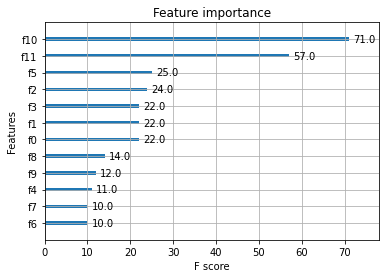

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [0]:
import xgboost
xgboost.plot_importance(xgbModel.bestModel.stages[-1].get_booster(), importance_type="weight")